# Constructing a consistent US County Per Capita Income Dataset 1969-2017

This notebook builds a cleaned geopackage for use in the inequality chapter of the book.  It does so by carrying out a number of data processing steps to:

- Generalize the boundaries of the county shapefile to faciltate processing
- Joining income attributes with geometries
- Handling the birth and deaths of counties over the time series

In [1]:
import pandas
from zipfile import ZipFile
import glob
from urllib.request import urlopen
from io import BytesIO

In [2]:
!pip install topojson

import fiona.io
import geopandas as gpd
import pandas
import requests
import topojson as tp

     |████████████████████████████████| 78 kB 1.8 MB/s eta 0:00:011


In [3]:
url = 'https://github.com/gdsbook/data_archive/raw/master/us_county_income/tl_2019_us_county.zip'

response = requests.get(url)
data_bytes = response.content

In [4]:
with fiona.io.ZipMemoryFile(data_bytes) as zip_memory_file:
    with zip_memory_file.open('tl_2019_us_county.shp') as collection:
        gdf = gpd.GeoDataFrame.from_features(collection, crs=collection.crs)
#gdf.to_file('tl_2019_us_county.shp')

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
gdf.shape

(3233, 18)

In [6]:
topo = tp.Topology(gdf, prequantize=False)


In [7]:
gdf_simplified = topo.toposimplify(5).to_gdf()


In [8]:
gdf_simplified.shape

(3233, 18)

In [9]:
gdf_simplified.to_file('tl_2019_us_county.shp')

## Read the remote file with county income data

In [10]:
caincurl = 'https://github.com/gdsbook/data_archive/raw/master/us_county_income/CAINC1.zip'
with urlopen(caincurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zf:
        zf.extractall()

In [11]:
csv_files = glob.glob("*.csv")

In [12]:
csv_files

['20.csv',
 '38.csv',
 'CAINC1_DE_1969_2017.csv',
 'CAINC1_DC_1969_2017.csv',
 'CAINC1_KY_1969_2017.csv',
 '18.csv',
 'CAINC1_KS_1969_2017.csv',
 '34.csv',
 'CAINC1_AK_1969_2017.csv',
 '08.csv',
 '09.csv',
 '47.csv',
 '11.csv',
 '04.csv',
 '44.csv',
 'CAINC1_AL_1969_2017.csv',
 'uscountyincome.csv',
 'CAINC1_AZ_1969_2017.csv',
 'CAINC1_WY_1969_2017.csv',
 '37.csv',
 '56.csv',
 '45.csv',
 '92.csv',
 'CAINC1_ID_1969_2017.csv',
 '46.csv',
 'virginia.csv',
 '00.csv',
 '93.csv',
 '33.csv',
 'CAINC1_LA_1969_2017.csv',
 'CAINC1_MN_1969_2017.csv',
 'CAINC1_GA_1969_2017.csv',
 'CAINC1_NH_1969_2017.csv',
 '49.csv',
 'CAINC1_WV_1969_2017.csv',
 'CAINC1_AR_1969_2017.csv',
 '19.csv',
 'CAINC1_MA_1969_2017.csv',
 'CAINC1_NY_1969_2017.csv',
 'CAINC1_UT_1969_2017.csv',
 'CAINC1_NV_1969_2017.csv',
 '17.csv',
 '51.csv',
 'CAINC1_TX_1969_2017.csv',
 '30.csv',
 'CAINC1_CA_1969_2017.csv',
 'CAINC1_WA_1969_2017.csv',
 'CAINC1_VT_1969_2017.csv',
 '40.csv',
 'CAINC1_IA_1969_2017.csv',
 '10.csv',
 'CAINC1_MI_1

In [13]:
data = pandas.read_csv('CAINC1__ALL_STATES_1969_2017.csv', encoding='latin-1', 
                      skipfooter=3, engine='python')

In [14]:
data.head()

,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,1970,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,"""00000""",United States,,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,791229000,855525000,...,12438527000,12051307000,12541995000,13315478000,13998383000,14175503000,14983140000,15711634000,16115630000,16820250000
1,"""00000""",United States,,CAINC1,2,...,Population (persons) 1/,Number of persons,201298000,203798722,...,304093966,306771529,309338421,311644280,313993272,316234505,318622525,321039839,323405935,325719178
2,"""00000""",United States,,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3931,4198,...,40904,39284,40545,42727,44582,44826,47025,48940,49831,51640
3,"""01000""",Alabama,5,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,9737715,10628318,...,157479528,155254669,161965527,167675590,172427855,174118716,180220290,187301605,190991192,198916425
4,"""01000""",Alabama,5,CAINC1,2,...,Population (persons) 1/,Number of persons,3440000,3449846,...,4718206,4757938,4785579,4798649,4813946,4827660,4840037,4850858,4860545,4874747


In [15]:
virginia = data[data.GeoFIPS.str.contains('\"51')] # select virginia
virginia.head()


,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,1970,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
8670,"""51000""",Virginia,5,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,17847652,19371643,...,356434411,348944176,364382497,386298008,404772481,402064568,420235927,440823733,448683501,466743276
8671,"""51000""",Virginia,5,CAINC1,2,...,Population (persons) 1/,Number of persons,4614000,4659930,...,7833496,7925937,8025206,8107548,8188656,8261689,8316902,8366767,8414380,8470020
8672,"""51000""",Virginia,5,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3868,4157,...,45501,44026,45405,47647,49431,48666,50528,52687,53323,55105
8673,"""51001""","Accomack, VA",5,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,72875,79372,...,1090928,1089574,1112288,1129193,1181700,1188926,1227111,1277179,1283155,1324623
8674,"""51001""","Accomack, VA",5,CAINC1,2,...,Population (persons) 1/,Number of persons,29308,28863,...,33970,33415,33147,33222,33264,32963,32965,32911,32818,32545


In [16]:
virginia.shape

(318, 57)

In [17]:
virginia.to_csv('virginia.csv')

In [18]:
data.head(20)

,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,1970,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,"""00000""",United States,,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,791229000,855525000,...,12438527000,12051307000,12541995000,13315478000,13998383000,14175503000,14983140000,15711634000,16115630000,16820250000
1,"""00000""",United States,,CAINC1,2,...,Population (persons) 1/,Number of persons,201298000,203798722,...,304093966,306771529,309338421,311644280,313993272,316234505,318622525,321039839,323405935,325719178
2,"""00000""",United States,,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3931,4198,...,40904,39284,40545,42727,44582,44826,47025,48940,49831,51640
3,"""01000""",Alabama,5,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,9737715,10628318,...,157479528,155254669,161965527,167675590,172427855,174118716,180220290,187301605,190991192,198916425
4,"""01000""",Alabama,5,CAINC1,2,...,Population (persons) 1/,Number of persons,3440000,3449846,...,4718206,4757938,4785579,4798649,4813946,4827660,4840037,4850858,4860545,4874747
5,"""01000""",Alabama,5,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,2831,3081,...,33377,32631,33844,34942,35818,36067,37235,38612,39294,40805
6,"""01001""","Autauga, AL",5,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,69973,77712,...,1751550,1764978,1829458,1894696,1924646,1939719,2012244,2116276,2183987,2247046
7,"""01001""","Autauga, AL",5,CAINC1,2,...,Population (persons) 1/,Number of persons,25166,24606,...,53277,54135,54750,55199,54927,54695,54864,54838,55278,55504
8,"""01001""","Autauga, AL",5,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,2780,3158,...,32876,32603,33415,34325,35040,35464,36677,38591,39509,40484
9,"""01003""","Baldwin, AL",5,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,157191,172745,...,6286039,6224967,6643563,7051666,7253460,7441318,7875234,8400864,8923673,9372465


In [19]:
data.tail(10)

,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,1970,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
9584,"""95000""",Southeast,5,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3198,3469,...,36869,35389,36475,38112,39418,39271,41206,42950,43723,45198
9585,"""96000""",Southwest,6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,56500512,62538485,...,1388296587,1320708181,1388502208,1504486401,1603075990,1642200054,1762040572,1805775989,1814966983,1894779972
9586,"""96000""",Southwest,6,CAINC1,2,...,Population (persons) 1/,Number of persons,16328000,16621375,...,36269039,36899289,37472786,37972888,38521426,39030404,39619086,40243759,40820143,41339800
9587,"""96000""",Southwest,6,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3460,3763,...,38278,35792,37054,39620,41615,42075,44475,44871,44463,45834
9588,"""97000""",Rocky Mountain,7,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,17805758,19931406,...,409181684,391528943,405707756,438403773,467422371,485385826,521692774,550009439,564264469,593926448
9589,"""97000""",Rocky Mountain,7,CAINC1,2,...,Population (persons) 1/,Number of persons,4943000,5037873,...,10609537,10793888,10949084,11079489,11215355,11366966,11514638,11689105,11878018,12055738
9590,"""97000""",Rocky Mountain,7,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3602,3956,...,38567,36273,37054,39569,41677,42701,45307,47053,47505,49265
9591,"""98000""",Far West,8,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,121725092,131575529,...,2230239645,2154405245,2246368991,2391122432,2547186492,2589966233,2777826261,2978517281,3098158645,3248359269
9592,"""98000""",Far West,8,CAINC1,2,...,Population (persons) 1/,Number of persons,26635000,27101402,...,51608614,52167532,52686778,53176406,53679832,54161802,54695081,55249155,55772858,56250544
9593,"""98000""",Far West,8,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,4570,4855,...,43214,41298,42636,44966,47451,47819,50787,53911,55550,57748


In [20]:
# fips codes source: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696
fips = """Alabama 	AL 	01
Alaska 	AK 	02
Arizona 	AZ 	04
Arkansas 	AR 	05
California 	CA 	06
Colorado 	CO 	08
Connecticut 	CT 	09
Delaware 	DE 	10
Florida 	FL 	12
Georgia 	GA 	13
Hawaii 	HI 	15
Idaho 	ID 	16
Illinois 	IL 	17
Indiana 	IN 	18
Iowa 	IA 	19
Kansas 	KS 	20
Kentucky 	KY 	21
Louisiana 	LA 	22
Maine 	ME 	23
Maryland 	MD 	24
Massachusetts 	MA 	25
Michigan 	MI 	26
Minnesota 	MN 	27
Mississippi 	MS 	28
Missouri 	MO 	29
Montana 	MT 	30
Nebraska 	NE 	31
Nevada 	NV 	32
New Hampshire 	NH 	33
New Jersey 	NJ 	34
New Mexico 	NM 	35
New York 	NY 	36
North Carolina 	NC 	37
North Dakota 	ND 	38
Ohio 	OH 	39
Oklahoma 	OK 	40
Oregon 	OR 	41
Pennsylvania 	PA 	42
Rhode Island 	RI 	44
South Carolina 	SC 	45
South Dakota 	SD 	46
Tennessee 	TN 	47
Texas 	TX 	48
Utah 	UT 	49
Vermont 	VT 	50
Virginia 	VA 	51
Washington 	WA 	53
West Virginia 	WV 	54
Wisconsin 	WI 	55
Wyoming 	WY 	56
American Samoa 	AS 	60
Guam 	GU 	66
Northern Mariana Islands 	MP 	69
Puerto Rico 	PR 	72
Virgin Islands 	VI 	78"""

In [21]:
fips_df = pandas.DataFrame([fip.split("\t") for fip in fips.split("\n")])
fips_df.columns=["State", "Abbreviation", 'FIPS']

In [22]:
fips_df

,State,Abbreviation,FIPS
0,Alabama,AL,01
1,Alaska,AK,02
2,Arizona,AZ,04
3,Arkansas,AR,05
4,California,CA,06
5,Colorado,CO,08
6,Connecticut,CT,09
7,Delaware,DE,10
8,Florida,FL,12
9,Georgia,GA,13


In [23]:
omit_fips = [" \""+str(fip) for fip in ['02', 15, 60, 66, 69, 72, 78, 90, 91, 92, 93, 94, 95, 96, 97, 98]]
omit_fips

[' "02',
 ' "15',
 ' "60',
 ' "66',
 ' "69',
 ' "72',
 ' "78',
 ' "90',
 ' "91',
 ' "92',
 ' "93',
 ' "94',
 ' "95',
 ' "96',
 ' "97',
 ' "98']

In [24]:
small = data.copy()
for omit in omit_fips:
    small = small[~small.GeoFIPS.str.contains(omit)]
    

In [25]:
small.shape

(9393, 57)

In [26]:
data.shape

(9594, 57)

In [27]:
geofips = set(code[:4] for code in data.GeoFIPS.values)

In [28]:
geofips

{' "00',
 ' "01',
 ' "02',
 ' "04',
 ' "05',
 ' "06',
 ' "08',
 ' "09',
 ' "10',
 ' "11',
 ' "12',
 ' "13',
 ' "15',
 ' "16',
 ' "17',
 ' "18',
 ' "19',
 ' "20',
 ' "21',
 ' "22',
 ' "23',
 ' "24',
 ' "25',
 ' "26',
 ' "27',
 ' "28',
 ' "29',
 ' "30',
 ' "31',
 ' "32',
 ' "33',
 ' "34',
 ' "35',
 ' "36',
 ' "37',
 ' "38',
 ' "39',
 ' "40',
 ' "41',
 ' "42',
 ' "44',
 ' "45',
 ' "46',
 ' "47',
 ' "48',
 ' "49',
 ' "50',
 ' "51',
 ' "53',
 ' "54',
 ' "55',
 ' "56',
 ' "91',
 ' "92',
 ' "93',
 ' "94',
 ' "95',
 ' "96',
 ' "97',
 ' "98'}

In [29]:
geofips = set(code[:4] for code in small.GeoFIPS.values)

In [30]:
geofips

{' "00',
 ' "01',
 ' "04',
 ' "05',
 ' "06',
 ' "08',
 ' "09',
 ' "10',
 ' "11',
 ' "12',
 ' "13',
 ' "16',
 ' "17',
 ' "18',
 ' "19',
 ' "20',
 ' "21',
 ' "22',
 ' "23',
 ' "24',
 ' "25',
 ' "26',
 ' "27',
 ' "28',
 ' "29',
 ' "30',
 ' "31',
 ' "32',
 ' "33',
 ' "34',
 ' "35',
 ' "36',
 ' "37',
 ' "38',
 ' "39',
 ' "40',
 ' "41',
 ' "42',
 ' "44',
 ' "45',
 ' "46',
 ' "47',
 ' "48',
 ' "49',
 ' "50',
 ' "51',
 ' "53',
 ' "54',
 ' "55',
 ' "56'}

In [31]:
small.shape

(9393, 57)

In [32]:
for fip in geofips:
    sdf = small[small.GeoFIPS.str.contains(fip)]
    sdf.to_csv(fip[2:]+".csv")

We are done as all the csv files have been extracted.

In [33]:
## old 015

In [34]:
import pandas
import geopandas
%matplotlib inline
from zipfile import ZipFile

import glob

## Read remote shapefile with county geometries

In [35]:
gdf = geopandas.read_file("tl_2019_us_county.shp")

## State Specific Data Frames

In [36]:
#gdf = geopandas.read_file("zip:tl_2019_us_county.zip!tl_2019_us_county.shp")
csv_files = glob.glob("??.csv")
csv_files.sort()
csv_files.pop(0) # kick out US

'00.csv'

In [37]:
mismatch = []
gdfs = []
#for csv_file in csv_files[:1]:
for csv_file in csv_files:

    #print(csv_file)
    csv = pandas.read_csv(csv_file)
    st = csv_file[:2]
    st_gdf = gdf[gdf.STATEFP==st]
    csv = csv.iloc[3:] # kick out the state level records
    nc, kc = csv.shape
    if nc/3 != st_gdf.shape[0]:
        mismatch.append(st)
        print(st)
    else:
        csv['GeoFIPS'] = [fip.strip().replace("\"", "") for fip in csv.GeoFIPS]
        csv['GEOID'] = csv.GeoFIPS.astype(str)
        merged_gdf = st_gdf.merge(csv, on='GEOID')
        gdfs.append(merged_gdf)
        

02
15
51
55


In [38]:
csv.GEOID

Series([], Name: GEOID, dtype: object)

In [39]:
len(gdfs)

55

In [40]:
gdf = pandas.concat(gdfs)

<AxesSubplot:>

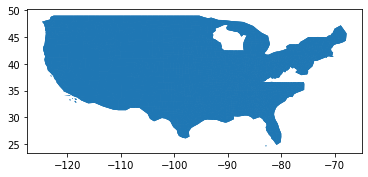

In [41]:
gdf.plot()

In [42]:
gdf.shape[0]/3

2903.0

In [43]:
gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,None,...,399915,388053,387623,365655,367837,376622,395399,417058,419915,444182
1,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,None,...,14161,14006,13900,13688,13434,13406,13440,13414,13410,13367
2,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,None,...,28241,27706,27887,26714,27381,28094,29420,31091,31314,33230
3,01,091,00161572,01091,Marengo,Marengo County,06,H1,G4020,None,...,631357,618986,643067,658510,672442,682230,703891,713222,717118,737908
4,01,091,00161572,01091,Marengo,Marengo County,06,H1,G4020,None,...,21331,21170,20944,20649,20360,20105,19975,19757,19505,19375


In [44]:
gdf.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'Unnamed: 0', 'GeoFIPS',
       'GeoName', 'Region', 'TableName', 'LineCode', 'IndustryClassification',
       'Description', 'Unit', '1969', '1970', '1971', '1972', '1973', '1974',
       '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983',
       '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')

In [45]:
years = [str(year) for year in range(1969,2018)]
dtypes = list(zip(years,[gdf[year].dtype for year in years]))


In [46]:
dtypes

[('1969', dtype('O')),
 ('1970', dtype('O')),
 ('1971', dtype('O')),
 ('1972', dtype('O')),
 ('1973', dtype('O')),
 ('1974', dtype('O')),
 ('1975', dtype('O')),
 ('1976', dtype('O')),
 ('1977', dtype('O')),
 ('1978', dtype('O')),
 ('1979', dtype('O')),
 ('1980', dtype('O')),
 ('1981', dtype('O')),
 ('1982', dtype('O')),
 ('1983', dtype('O')),
 ('1984', dtype('O')),
 ('1985', dtype('O')),
 ('1986', dtype('O')),
 ('1987', dtype('O')),
 ('1988', dtype('O')),
 ('1989', dtype('O')),
 ('1990', dtype('O')),
 ('1991', dtype('O')),
 ('1992', dtype('O')),
 ('1993', dtype('O')),
 ('1994', dtype('O')),
 ('1995', dtype('O')),
 ('1996', dtype('O')),
 ('1997', dtype('O')),
 ('1998', dtype('O')),
 ('1999', dtype('O')),
 ('2000', dtype('O')),
 ('2001', dtype('O')),
 ('2002', dtype('O')),
 ('2003', dtype('O')),
 ('2004', dtype('O')),
 ('2005', dtype('O')),
 ('2006', dtype('O')),
 ('2007', dtype('O')),
 ('2008', dtype('O')),
 ('2009', dtype('O')),
 ('2010', dtype('O')),
 ('2011', dtype('O')),
 ('2012', d

## Issues

1. Virginia
2. Wisconsin
3. Object data types for 1969-2001

In [47]:
gdf.to_file('pcincome0.shp')

In [48]:
# old 020

## Virginia independent cities

Reference https://en.wikipedia.org/wiki/Independent_city_(United_States)

> In the United States, an independent city is a city that is not in the territory of any county or counties with exceptions noted below. Of the 41 independent U.S. cities,[1] 38 are in Virginia, whose state constitution makes them a special case. The three independent cities outside Virginia are Baltimore, Maryland; St. Louis, Missouri; and Carson City, Nevada. The U.S. Census Bureau uses counties as its base unit for presentation of statistical information, and treats independent cities as county equivalents for those purposes. The most populous of them is Baltimore, Maryland. 


### From BEA Income Data:
> Virginia combination areas consist of one or two independent cities with 1980 populations of less than 100,000 combined with an adjacent county. The county name appears first, followed by the city name(s). Separate estimates for the jurisdictions making up the combination area are not available. Bedford County, VA includes the independent city of Bedford for all years.

### Virginia
> The Commonwealth of Virginia is divided into 95 counties, along with 38 independent cities that are considered county-equivalents for census purposes. The map in this article, taken from the official United States Census Bureau site, includes Clifton Forge and Bedford as independent cities. This reflected the political reality at the time of the 2000 Census. However, both have since chosen to revert to town status. In Virginia, cities are co-equal levels of government to counties, but towns are part of counties. For some counties, for statistical purposes, the Bureau of Economic Analysis combines any independent cities with the county that it was once part of (before the legislation creating independent cities took place in 1871).

[Source](https://en.wikipedia.org/wiki/List_of_cities_and_counties_in_Virginia)

### Approach

Dissolve boundaries of independent cities that BEA does not disclose values for with their adjacent county.

In [49]:

csv = pandas.read_csv('51.csv')

In [50]:
csv.head()

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,8670,"""51000""",Virginia,5,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,17847652,...,356434411,348944176,364382497,386298008,404772481,402064568,420235927,440823733,448683501,466743276
1,8671,"""51000""",Virginia,5,CAINC1,2,...,Population (persons) 1/,Number of persons,4614000,...,7833496,7925937,8025206,8107548,8188656,8261689,8316902,8366767,8414380,8470020
2,8672,"""51000""",Virginia,5,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3868,...,45501,44026,45405,47647,49431,48666,50528,52687,53323,55105
3,8673,"""51001""","Accomack, VA",5,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,72875,...,1090928,1089574,1112288,1129193,1181700,1188926,1227111,1277179,1283155,1324623
4,8674,"""51001""","Accomack, VA",5,CAINC1,2,...,Population (persons) 1/,Number of persons,29308,...,33970,33415,33147,33222,33264,32963,32965,32911,32818,32545


In [51]:
csv['GeoFIPS'] = [fip.strip().replace("\"", "") for fip in csv.GeoFIPS]

In [52]:
gdf = geopandas.read_file('tl_2019_us_county.shp')

gdf = geopandas.read_file("zip:tl_2019_us_county.zip!tl_2019_us_county.shp")
zipfile = "zip:tl_2019_us_county.zip!tl_2019_us_county.shp"

In [53]:
virginia_gdf = gdf[gdf.STATEFP=="51"]

<AxesSubplot:>

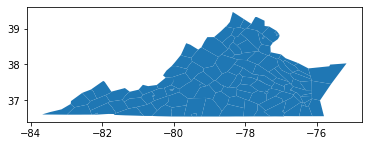

In [54]:
virginia_gdf.plot()

In [55]:
virginia_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
27,51,775,01789074,51775,Salem,Salem city,25,C7,G4020,None,40220,None,F,37602710,275156,+37.2853329,-080.0552407,"POLYGON ((-80.12049 37.28705, -80.02223 37.308..."
28,51,121,01674630,51121,Montgomery,Montgomery County,06,H1,G4020,None,13980,None,A,1001921573,6289787,+37.1755344,-080.3877913,"POLYGON ((-80.55224 37.16172, -80.60696 37.244..."
36,51,735,01498436,51735,Poquoson,Poquoson city,25,C7,G4020,545,47260,None,F,39837595,163455830,+37.1283599,-076.3035337,"POLYGON ((-76.41367 37.13862, -76.13552 37.191..."
39,51,095,01480135,51095,James City,James City County,06,H1,G4020,545,47260,None,A,368724192,95246387,+37.3248367,-076.7778878,"POLYGON ((-76.89270 37.42427, -76.74198 37.467..."
49,51,179,01480173,51179,Stafford,Stafford County,06,H1,G4020,548,47900,47894,A,697237202,28088011,+38.4132608,-077.4513342,"POLYGON ((-77.58878 38.50404, -77.53133 38.556..."


In [56]:
data = csv

In [57]:
data.head()

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,8670,51000,Virginia,5,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,17847652,...,356434411,348944176,364382497,386298008,404772481,402064568,420235927,440823733,448683501,466743276
1,8671,51000,Virginia,5,CAINC1,2,...,Population (persons) 1/,Number of persons,4614000,...,7833496,7925937,8025206,8107548,8188656,8261689,8316902,8366767,8414380,8470020
2,8672,51000,Virginia,5,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3868,...,45501,44026,45405,47647,49431,48666,50528,52687,53323,55105
3,8673,51001,"Accomack, VA",5,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,72875,...,1090928,1089574,1112288,1129193,1181700,1188926,1227111,1277179,1283155,1324623
4,8674,51001,"Accomack, VA",5,CAINC1,2,...,Population (persons) 1/,Number of persons,29308,...,33970,33415,33147,33222,33264,32963,32965,32911,32818,32545


In [58]:
data['GEOID'] = data.GeoFIPS

In [59]:
data.GEOID

0      51000
1      51000
2      51000
3      51001
4      51001
       ...  
313    51955
314    51955
315    51958
316    51958
317    51958
Name: GEOID, Length: 318, dtype: object

## gdf records missing income values

In [60]:
#data = data[data.LineCode==3]
merged_gdf = virginia_gdf.merge(data, on='GEOID')

<AxesSubplot:>

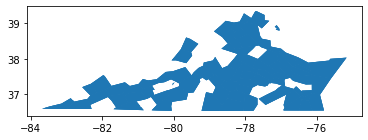

In [61]:
merged_gdf.plot()

In [62]:
merged_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,51,179,01480173,51179,Stafford,Stafford County,06,H1,G4020,548,...,5598667,5771841,6051523,6377898,6564332,6618516,6806720,7145523,7413434,7779485
1,51,179,01480173,51179,Stafford,Stafford County,06,H1,G4020,548,...,124323,126449,129822,132207,133376,135978,138802,140891,143477,146649
2,51,179,01480173,51179,Stafford,Stafford County,06,H1,G4020,548,...,45033,45646,46614,48242,49217,48673,49039,50717,51670,53048
3,51,181,01480174,51181,Surry,Surry County,06,H1,G4020,None,...,236619,237659,235027,241403,244447,243534,255985,274412,263711,277471
4,51,181,01480174,51181,Surry,Surry County,06,H1,G4020,None,...,7061,7037,7045,6923,6839,6788,6781,6670,6570,6540


In [63]:
merged_gdf.shape[0]/3

82.0

In [64]:
matched_names = set(merged_gdf.NAMELSAD)

In [65]:
matched_names

{'Accomack County',
 'Alexandria city',
 'Amelia County',
 'Amherst County',
 'Appomattox County',
 'Arlington County',
 'Bath County',
 'Bedford County',
 'Bland County',
 'Botetourt County',
 'Brunswick County',
 'Buchanan County',
 'Buckingham County',
 'Caroline County',
 'Charles City County',
 'Charlotte County',
 'Chesapeake city',
 'Chesterfield County',
 'Clarke County',
 'Craig County',
 'Culpeper County',
 'Cumberland County',
 'Dickenson County',
 'Essex County',
 'Fauquier County',
 'Floyd County',
 'Fluvanna County',
 'Franklin County',
 'Giles County',
 'Gloucester County',
 'Goochland County',
 'Grayson County',
 'Greene County',
 'Halifax County',
 'Hampton city',
 'Hanover County',
 'Henrico County',
 'Highland County',
 'Isle of Wight County',
 'King George County',
 'King William County',
 'King and Queen County',
 'Lancaster County',
 'Lee County',
 'Loudoun County',
 'Louisa County',
 'Lunenburg County',
 'Madison County',
 'Mathews County',
 'Mecklenburg County',

In [66]:
missing_gdf = virginia_gdf[~virginia_gdf.GEOID.isin(merged_gdf.GEOID)]

In [67]:
missing_names = set(missing_gdf.NAMELSAD)

In [68]:
missing_names

{'Albemarle County',
 'Alleghany County',
 'Augusta County',
 'Bristol city',
 'Buena Vista city',
 'Campbell County',
 'Carroll County',
 'Charlottesville city',
 'Colonial Heights city',
 'Covington city',
 'Danville city',
 'Dinwiddie County',
 'Emporia city',
 'Fairfax County',
 'Fairfax city',
 'Falls Church city',
 'Franklin city',
 'Frederick County',
 'Fredericksburg city',
 'Galax city',
 'Greensville County',
 'Harrisonburg city',
 'Henry County',
 'Hopewell city',
 'James City County',
 'Lexington city',
 'Lynchburg city',
 'Manassas Park city',
 'Manassas city',
 'Martinsville city',
 'Montgomery County',
 'Norton city',
 'Petersburg city',
 'Pittsylvania County',
 'Poquoson city',
 'Prince George County',
 'Prince William County',
 'Radford city',
 'Roanoke County',
 'Rockbridge County',
 'Rockingham County',
 'Salem city',
 'Southampton County',
 'Spotsylvania County',
 'Staunton city',
 'Washington County',
 'Waynesboro city',
 'Williamsburg city',
 'Winchester city',
 '

<AxesSubplot:>

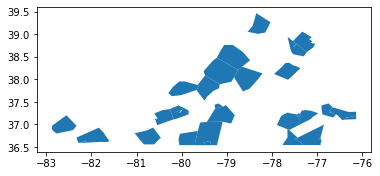

In [69]:
missing_gdf.plot()

In [70]:
missing_gdf.shape

(51, 18)

In [71]:
missing_gdf

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
27,51,775,01789074,51775,Salem,Salem city,25,C7,G4020,None,40220,None,F,37602710,275156,+37.2853329,-080.0552407,"POLYGON ((-80.12049 37.28705, -80.02223 37.308..."
28,51,121,01674630,51121,Montgomery,Montgomery County,06,H1,G4020,None,13980,None,A,1001921573,6289787,+37.1755344,-080.3877913,"POLYGON ((-80.55224 37.16172, -80.60696 37.244..."
36,51,735,01498436,51735,Poquoson,Poquoson city,25,C7,G4020,545,47260,None,F,39837595,163455830,+37.1283599,-076.3035337,"POLYGON ((-76.41367 37.13862, -76.13552 37.191..."
39,51,095,01480135,51095,James City,James City County,06,H1,G4020,545,47260,None,A,368724192,95246387,+37.3248367,-076.7778878,"POLYGON ((-76.89270 37.42427, -76.74198 37.467..."
268,51,089,01502770,51089,Henry,Henry County,06,H1,G4020,None,32300,None,A,990284619,5269785,+36.7814785,-079.7592313,"POLYGON ((-80.06909 36.67402, -80.04149 36.794..."
302,51,540,01789068,51540,Charlottesville,Charlottesville city,25,C7,G4020,None,16820,None,F,26533570,47161,+38.0376579,-078.4853806,"POLYGON ((-78.52368 38.02233, -78.48520 38.068..."
317,51,820,01498443,51820,Waynesboro,Waynesboro city,25,C7,G4020,277,44420,None,F,38771594,364644,+38.0671571,-078.9014197,"POLYGON ((-78.94851 38.06810, -78.94320 38.062..."
377,51,595,01498422,51595,Emporia,Emporia city,25,C7,G4020,None,None,None,F,17881071,165621,+36.6961820,-077.5359753,"POLYGON ((-77.56389 36.70307, -77.56108 36.697..."
402,51,580,01789069,51580,Covington,Covington city,25,C7,G4020,None,None,None,F,14163842,521492,+37.7810603,-079.9854337,"POLYGON ((-80.00899 37.76259, -80.00889 37.762..."
423,51,005,01673675,51005,Alleghany,Alleghany County,06,H1,G4020,None,None,None,A,1156608818,8170515,+37.7879048,-080.0086690,"POLYGON ((-80.20146 37.82581, -80.05606 37.951..."


In [72]:
#names = missing_gdf.NAME
names = missing_gdf.NAMELSAD

In [73]:
virginia_income = data[data.GeoName.str.contains(", VA")]

In [74]:
virginia_income.shape

(315, 59)

In [75]:
virginia_income.head()

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,GEOID
3,8673,51001,"Accomack, VA",5,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,72875,...,1089574,1112288,1129193,1181700,1188926,1227111,1277179,1283155,1324623,51001
4,8674,51001,"Accomack, VA",5,CAINC1,2,...,Population (persons) 1/,Number of persons,29308,...,33415,33147,33222,33264,32963,32965,32911,32818,32545,51001
5,8675,51001,"Accomack, VA",5,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,2487,...,32607,33556,33989,35525,36069,37225,38807,39099,40701,51001
6,8676,51007,"Amelia, VA",5,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,18123,...,403821,427150,437215,459614,493801,509705,535479,538046,560273,51007
7,8677,51007,"Amelia, VA",5,CAINC1,2,...,Population (persons) 1/,Number of persons,7702,...,12594,12746,12752,12747,12659,12717,12784,12830,13020,51007


In [76]:
geonames = pandas.unique(virginia_income.GeoName)

In [77]:
geonames

array(['Accomack, VA', 'Amelia, VA', 'Amherst, VA', 'Appomattox, VA',
       'Arlington, VA', 'Bath, VA', 'Bedford, VA*', 'Bland, VA',
       'Botetourt, VA', 'Brunswick, VA', 'Buchanan, VA', 'Buckingham, VA',
       'Caroline, VA', 'Charles City, VA', 'Charlotte, VA',
       'Chesterfield, VA', 'Clarke, VA', 'Craig, VA', 'Culpeper, VA',
       'Cumberland, VA', 'Dickenson, VA', 'Essex, VA', 'Fauquier, VA',
       'Floyd, VA', 'Fluvanna, VA', 'Franklin, VA', 'Giles, VA',
       'Gloucester, VA', 'Goochland, VA', 'Grayson, VA', 'Greene, VA',
       'Halifax, VA', 'Hanover, VA', 'Henrico, VA', 'Highland, VA',
       'Isle of Wight, VA', 'King and Queen, VA', 'King George, VA',
       'King William, VA', 'Lancaster, VA', 'Lee, VA', 'Loudoun, VA',
       'Louisa, VA', 'Lunenburg, VA', 'Madison, VA', 'Mathews, VA',
       'Mecklenburg, VA', 'Middlesex, VA', 'Nelson, VA', 'New Kent, VA',
       'Northampton, VA', 'Northumberland, VA', 'Nottoway, VA',
       'Orange, VA', 'Page, VA', 'Patrick

In [78]:
class Combination:
    def __init__(self, label):
        n_commas = label.count(",")
        self.label = label
        self.n_commas = n_commas
        if "Fairfax City" in label:
            label = label.replace('Fairfax City', 'Fairfax')
        if n_commas == 1:
            if "Bedford" in label:
                self.county = 'Bedford'
                self.cities = []
            else:
                words = label.split("+")
                county = words[0].strip()
                self.county = county
                self.cities = [words[-1].split(",")[0].strip()+" city"]
        elif n_commas == 2:
            words = label.split(",")
            self.county = words[0].strip()
            cities = words[1]
            cities = cities.split("+")
            
            self.cities = [city.strip()+" city" for city in cities]
        else:
            print('Bad label: ', label)
        self.county = self.county + " County"
        self.NAMELSAD = self.label
        

In [79]:
combinations_0 = [name for name in geonames if "VA*" in name]
combinations = [Combination(c) for c in combinations_0]

In [80]:
c0 = combinations[0]
c0.label

'Bedford, VA*'

In [81]:
matches = {}
for name in names:
    hits = []
    matches[name] = []
    if "city" in name:
        hits = [comb for comb in combinations if name in comb.cities]
    else:
        hits = [comb for comb in combinations if name == comb.county]
    if hits:
        matches[name] = hits[0].label
    
        
        

## Match combinations to rows of df

In [82]:
for combination in combinations:
    print("label: ",combination.label)
    comb_names = [combination.county]+combination.cities
    print(comb_names)

label:  Bedford, VA*
['Bedford County']
label:  Albemarle + Charlottesville, VA*
['Albemarle County', 'Charlottesville city']
label:  Alleghany + Covington, VA*
['Alleghany County', 'Covington city']
label:  Augusta, Staunton + Waynesboro, VA*
['Augusta County', 'Staunton city', 'Waynesboro city']
label:  Campbell + Lynchburg, VA*
['Campbell County', 'Lynchburg city']
label:  Carroll + Galax, VA*
['Carroll County', 'Galax city']
label:  Dinwiddie, Colonial Heights + Petersburg, VA*
['Dinwiddie County', 'Colonial Heights city', 'Petersburg city']
label:  Fairfax, Fairfax City + Falls Church, VA*
['Fairfax County', 'Fairfax city', 'Falls Church city']
label:  Frederick + Winchester, VA*
['Frederick County', 'Winchester city']
label:  Greensville + Emporia, VA*
['Greensville County', 'Emporia city']
label:  Henry + Martinsville, VA*
['Henry County', 'Martinsville city']
label:  James City + Williamsburg, VA*
['James City County', 'Williamsburg city']
label:  Montgomery + Radford, VA*
['Mo

In [83]:
merged_dfs = []
geoids = []
for combination in combinations:
    places = combination.cities + [combination.county]
    print(places)
    rows = virginia_gdf[virginia_gdf.NAMELSAD.isin(places)]
    
    if len(rows) != len(places):
        print('missed:', places)
    #d_df = rows.dissolve(by='STATEFP')
    rd = rows.dissolve(by='STATEFP').head()
    rd['NAMELSAD']= combination.label
    geoid = virginia_income[virginia_income.GeoName==combination.label].GEOID.values[0]
    rd['GEOID'] = geoid
    merged_dfs.append(rd)
    

['Bedford County']
['Charlottesville city', 'Albemarle County']
['Covington city', 'Alleghany County']
['Staunton city', 'Waynesboro city', 'Augusta County']
['Lynchburg city', 'Campbell County']
['Galax city', 'Carroll County']
['Colonial Heights city', 'Petersburg city', 'Dinwiddie County']
['Fairfax city', 'Falls Church city', 'Fairfax County']
['Winchester city', 'Frederick County']
['Emporia city', 'Greensville County']
['Martinsville city', 'Henry County']
['Williamsburg city', 'James City County']
['Radford city', 'Montgomery County']
['Danville city', 'Pittsylvania County']
['Hopewell city', 'Prince George County']
['Manassas city', 'Manassas Park city', 'Prince William County']
['Salem city', 'Roanoke County']
['Buena Vista city', 'Lexington city', 'Rockbridge County']
['Harrisonburg city', 'Rockingham County']
['Franklin city', 'Southampton County']
['Fredericksburg city', 'Spotsylvania County']
['Bristol city', 'Washington County']
['Norton city', 'Wise County']
['Poquoson c

In [84]:
rows.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
36,51,735,01498436,51735,Poquoson,Poquoson city,25,C7,G4020,545,47260,None,F,39837595,163455830,+37.1283599,-076.3035337,"POLYGON ((-76.41367 37.13862, -76.13552 37.191..."
2966,51,199,01480182,51199,York,York County,06,H1,G4020,545,47260,None,A,270935371,285552364,+37.2190813,-076.5616481,"POLYGON ((-76.56519 37.22054, -76.59130 37.213..."


In [85]:
rd.head()

,geometry,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
STATEFP,,,,,,,,,,,,,,,,,
51,"POLYGON ((-76.13552 37.19197, -76.13494 37.117...",735,01498436,51958,Poquoson,"York + Poquoson, VA*",25,C7,G4020,545,47260,None,F,39837595,163455830,+37.1283599,-076.3035337


In [86]:
dissolved = pandas.concat(merged_dfs)

In [87]:
dissolved.head()

,geometry,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
STATEFP,,,,,,,,,,,,,,,,,
51,"POLYGON ((-79.63421 37.45702, -79.49870 37.532...",019,01674818,51019,Bedford,"Bedford, VA*",06,H1,G4020,None,31340,None,A,1968605128,42118517,+37.3122568,-079.5272234
51,"POLYGON ((-78.80140 37.98263, -78.83887 38.047...",540,01789068,51901,Charlottesville,"Albemarle + Charlottesville, VA*",25,C7,G4020,None,16820,None,F,26533570,47161,+38.0376579,-078.4853806
51,"POLYGON ((-80.20146 37.82581, -80.05606 37.951...",580,01789069,51903,Covington,"Alleghany + Covington, VA*",25,C7,G4020,None,None,None,F,14163842,521492,+37.7810603,-079.9854337
51,"POLYGON ((-79.36786 38.01803, -79.48267 38.086...",820,01498443,51907,Waynesboro,"Augusta, Staunton + Waynesboro, VA*",25,C7,G4020,277,44420,None,F,38771594,364644,+38.0671571,-078.9014197
51,"POLYGON ((-79.30244 37.28438, -79.25795 37.355...",031,01674917,51911,Campbell,"Campbell + Lynchburg, VA*",06,H1,G4020,None,31340,None,A,1303300941,8894442,+37.2101515,-079.0954282


In [88]:
d_merge = dissolved.merge(virginia_income, on='GEOID')

In [89]:
d_merge.head()

,geometry,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,"POLYGON ((-79.63421 37.45702, -79.49870 37.532...",019,01674818,51019,Bedford,"Bedford, VA*",06,H1,G4020,None,...,2696045,2678191,2715575,2838513,2973578,3001522,3129081,3297923,3311202,3417264
1,"POLYGON ((-79.63421 37.45702, -79.49870 37.532...",019,01674818,51019,Bedford,"Bedford, VA*",06,H1,G4020,None,...,73744,74573,75040,75560,75758,76195,77035,77562,77828,77974
2,"POLYGON ((-79.63421 37.45702, -79.49870 37.532...",019,01674818,51019,Bedford,"Bedford, VA*",06,H1,G4020,None,...,36560,35914,36188,37566,39251,39393,40619,42520,42545,43826
3,"POLYGON ((-78.80140 37.98263, -78.83887 38.047...",540,01789068,51901,Charlottesville,"Albemarle + Charlottesville, VA*",25,C7,G4020,None,...,7188821,6825990,7209179,7623402,8402062,8270217,8881388,9494461,9981222,10531351
4,"POLYGON ((-78.80140 37.98263, -78.83887 38.047...",540,01789068,51901,Charlottesville,"Albemarle + Charlottesville, VA*",25,C7,G4020,None,...,139211,141125,142703,144094,146077,147430,149410,151694,153705,155721


In [90]:
d_merge.shape

(72, 75)

<AxesSubplot:>

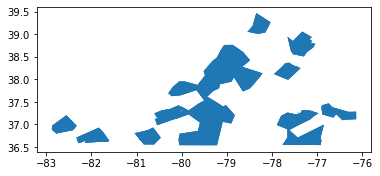

In [91]:
d_merge.plot()

<AxesSubplot:>

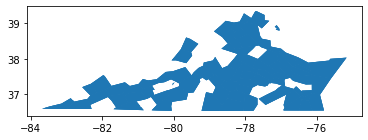

In [92]:
merged_gdf.plot()

<AxesSubplot:>

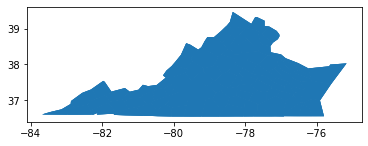

In [93]:
final_gdf = pandas.concat([merged_gdf, d_merge])
final_gdf.plot()

In [94]:
final_gdf.shape

(318, 76)

In [95]:
virginia_gdf.shape

(133, 18)

In [96]:
final_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,51,179,01480173,51179,Stafford,Stafford County,06,H1,G4020,548,...,5598667,5771841,6051523,6377898,6564332,6618516,6806720,7145523,7413434,7779485
1,51,179,01480173,51179,Stafford,Stafford County,06,H1,G4020,548,...,124323,126449,129822,132207,133376,135978,138802,140891,143477,146649
2,51,179,01480173,51179,Stafford,Stafford County,06,H1,G4020,548,...,45033,45646,46614,48242,49217,48673,49039,50717,51670,53048
3,51,181,01480174,51181,Surry,Surry County,06,H1,G4020,None,...,236619,237659,235027,241403,244447,243534,255985,274412,263711,277471
4,51,181,01480174,51181,Surry,Surry County,06,H1,G4020,None,...,7061,7037,7045,6923,6839,6788,6781,6670,6570,6540


In [97]:
final_gdf.tail()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
67,NaN,720,01498434,51955,Norton,"Wise + Norton, VA*",25,C7,G4020,None,...,45350,45357,45583,45535,45034,44764,44036,43567,43022,42522
68,NaN,720,01498434,51955,Norton,"Wise + Norton, VA*",25,C7,G4020,None,...,27531,28516,30485,31511,30802,29494,30164,30893,30533,31849
69,NaN,735,01498436,51958,Poquoson,"York + Poquoson, VA*",25,C7,G4020,545,...,3686780,3620374,3738324,3869473,3974745,4005287,4201387,4325492,4378441,4529273
70,NaN,735,01498436,51958,Poquoson,"York + Poquoson, VA*",25,C7,G4020,545,...,77047,77350,77440,77900,78003,78170,78605,79834,79689,79792
71,NaN,735,01498436,51958,Poquoson,"York + Poquoson, VA*",25,C7,G4020,545,...,47851,46805,48274,49672,50956,51238,53449,54181,54944,56763


<AxesSubplot:>

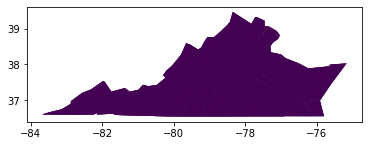

In [98]:
final_gdf.plot(column='1978')

In [99]:
final_gdf['1979'] = final_gdf['1979'].astype(int)

<AxesSubplot:>

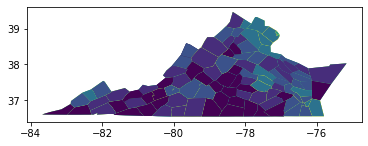

In [100]:
final_gdf.plot(column='1979', legend=False, scheme='Quantiles', k=9)

In [101]:
final_gdf.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'Unnamed: 0', 'GeoFIPS',
       'GeoName', 'Region', 'TableName', 'LineCode', 'IndustryClassification',
       'Description', 'Unit', '1969', '1970', '1971', '1972', '1973', '1974',
       '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983',
       '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')

In [102]:
final_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,51,179,01480173,51179,Stafford,Stafford County,06,H1,G4020,548,...,5598667,5771841,6051523,6377898,6564332,6618516,6806720,7145523,7413434,7779485
1,51,179,01480173,51179,Stafford,Stafford County,06,H1,G4020,548,...,124323,126449,129822,132207,133376,135978,138802,140891,143477,146649
2,51,179,01480173,51179,Stafford,Stafford County,06,H1,G4020,548,...,45033,45646,46614,48242,49217,48673,49039,50717,51670,53048
3,51,181,01480174,51181,Surry,Surry County,06,H1,G4020,None,...,236619,237659,235027,241403,244447,243534,255985,274412,263711,277471
4,51,181,01480174,51181,Surry,Surry County,06,H1,G4020,None,...,7061,7037,7045,6923,6839,6788,6781,6670,6570,6540


In [103]:
final_gdf.shape

(318, 76)

In [104]:
327859/37657 * 1000

8706.455639057811

In [105]:
318/3


106.0

In [106]:
final_gdf.STATEFP='51'

In [107]:
final_gdf[final_gdf.NAME=='Charlottesville']

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
3,51,540,01789068,51901,Charlottesville,"Albemarle + Charlottesville, VA*",25,C7,G4020,None,...,7188821,6825990,7209179,7623402,8402062,8270217,8881388,9494461,9981222,10531351
4,51,540,01789068,51901,Charlottesville,"Albemarle + Charlottesville, VA*",25,C7,G4020,None,...,139211,141125,142703,144094,146077,147430,149410,151694,153705,155721
5,51,540,01789068,51901,Charlottesville,"Albemarle + Charlottesville, VA*",25,C7,G4020,None,...,51640,48368,50519,52906,57518,56096,59443,62590,64938,67630


In [108]:
727271*1000/93879

7746.8976022326615

## Reverse Matching

Which income records do not match a record in the shapefile

In [109]:
virginia_gdf = gdf[gdf.STATEFP=="51"]

In [110]:
#data = data[data.LineCode==3]
merged_df = data.merge(virginia_gdf, on='GEOID')

In [111]:
merged_df.shape

(246, 76)

In [112]:
missing_df = data[~data.GEOID.isin(merged_df.GEOID)]
#~virginia_gdf.GEOID.isin(merged_gdf.GEOID)

In [113]:
set(missing_df.GeoName)

{'Albemarle + Charlottesville, VA*',
 'Alleghany + Covington, VA*',
 'Augusta, Staunton + Waynesboro, VA*',
 'Campbell + Lynchburg, VA*',
 'Carroll + Galax, VA*',
 'Dinwiddie, Colonial Heights + Petersburg, VA*',
 'Fairfax, Fairfax City + Falls Church, VA*',
 'Frederick + Winchester, VA*',
 'Greensville + Emporia, VA*',
 'Henry + Martinsville, VA*',
 'James City + Williamsburg, VA*',
 'Montgomery + Radford, VA*',
 'Pittsylvania + Danville, VA*',
 'Prince George + Hopewell, VA*',
 'Prince William, Manassas + Manassas Park, VA*',
 'Roanoke + Salem, VA*',
 'Rockbridge, Buena Vista + Lexington, VA*',
 'Rockingham + Harrisonburg, VA*',
 'Southampton + Franklin, VA*',
 'Spotsylvania + Fredericksburg, VA*',
 'Virginia',
 'Washington + Bristol, VA*',
 'Wise + Norton, VA*',
 'York + Poquoson, VA*'}

In [114]:
pcincome_gdf = geopandas.read_file('pcincome0.shp')

In [115]:
pcincome_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,geometry
0,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,None,...,388053,387623,365655,367837,376622,395399,417058,419915,444182,"POLYGON ((-85.97879 33.32757, -85.85189 33.498..."
1,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,None,...,14006,13900,13688,13434,13406,13440,13414,13410,13367,"POLYGON ((-85.97879 33.32757, -85.85189 33.498..."
2,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,None,...,27706,27887,26714,27381,28094,29420,31091,31314,33230,"POLYGON ((-85.97879 33.32757, -85.85189 33.498..."
3,01,091,00161572,01091,Marengo,Marengo County,06,H1,G4020,None,...,618986,643067,658510,672442,682230,703891,713222,717118,737908,"POLYGON ((-87.92970 32.29252, -87.93066 32.310..."
4,01,091,00161572,01091,Marengo,Marengo County,06,H1,G4020,None,...,21170,20944,20649,20360,20105,19975,19757,19505,19375,"POLYGON ((-87.92970 32.29252, -87.93066 32.310..."


In [116]:
final_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,51,179,01480173,51179,Stafford,Stafford County,06,H1,G4020,548,...,5598667,5771841,6051523,6377898,6564332,6618516,6806720,7145523,7413434,7779485
1,51,179,01480173,51179,Stafford,Stafford County,06,H1,G4020,548,...,124323,126449,129822,132207,133376,135978,138802,140891,143477,146649
2,51,179,01480173,51179,Stafford,Stafford County,06,H1,G4020,548,...,45033,45646,46614,48242,49217,48673,49039,50717,51670,53048
3,51,181,01480174,51181,Surry,Surry County,06,H1,G4020,None,...,236619,237659,235027,241403,244447,243534,255985,274412,263711,277471
4,51,181,01480174,51181,Surry,Surry County,06,H1,G4020,None,...,7061,7037,7045,6923,6839,6788,6781,6670,6570,6540


In [117]:
final_gdf.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'Unnamed: 0', 'GeoFIPS',
       'GeoName', 'Region', 'TableName', 'LineCode', 'IndustryClassification',
       'Description', 'Unit', '1969', '1970', '1971', '1972', '1973', '1974',
       '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983',
       '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')

In [118]:
pcincome_gdf.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'Unnamed_ 0', 'GeoFIPS', 'GeoName',
       'Region', 'TableName', 'LineCode', 'IndustryCl', 'Descriptio', 'Unit',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', 'geometry'],
      dtype='object')

In [119]:
common = set(pcincome_gdf.columns).intersection(final_gdf.columns)

In [120]:
common

{'1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 'ALAND',
 'AWATER',
 'CBSAFP',
 'CLASSFP',
 'COUNTYFP',
 'COUNTYNS',
 'CSAFP',
 'FUNCSTAT',
 'GEOID',
 'GeoFIPS',
 'GeoName',
 'INTPTLAT',
 'INTPTLON',
 'LSAD',
 'LineCode',
 'METDIVFP',
 'MTFCC',
 'NAME',
 'NAMELSAD',
 'Region',
 'STATEFP',
 'TableName',
 'Unit',
 'geometry'}

In [121]:
us = pcincome_gdf[common]

In [122]:
va = final_gdf[common]


In [123]:
va.reset_index(inplace=True)

In [124]:
dup = va[va[["NAME", "GEOID", "1969"]].duplicated()]

In [125]:
dup.NAME

246    Bedford
247    Bedford
248    Bedford
Name: NAME, dtype: object

In [126]:
dup

,index,Unit,MTFCC,ALAND,1996,2004,TableName,2003,1979,1976,...,2008,1994,Region,1977,1972,COUNTYNS,GEOID,LSAD,1998,NAMELSAD
246,0,Thousands of dollars,G4020,1968605128,1418384,2130053,CAINC1,2057771,311832,203128,...,2696045,1202511,5,231707,126140,01674818,51019,06,1688035,"Bedford, VA*"
247,1,Number of persons,G4020,1968605128,62320,69761,CAINC1,68678,40243,36657,...,73744,58776,5,37336,33641,01674818,51019,06,64763,"Bedford, VA*"
248,2,Dollars,G4020,1968605128,22760,30534,CAINC1,29963,7749,5541,...,36560,20459,5,6206,3750,01674818,51019,06,26065,"Bedford, VA*"


In [127]:
va = va.drop(dup.index)

In [128]:
usva = pandas.concat([us,va])

<AxesSubplot:>

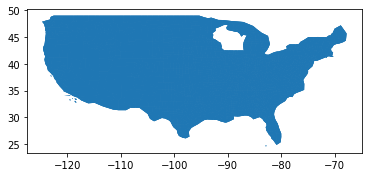

In [129]:
usva.plot()

In [130]:
usva.shape

(9024, 74)

In [131]:
9027/3

3009.0

In [132]:
years = [str(year) for year in range(1969,2018)]
dtypes = list(zip(years,[usva[year].dtype for year in years]))
dtypes

[('1969', dtype('O')),
 ('1970', dtype('O')),
 ('1971', dtype('O')),
 ('1972', dtype('O')),
 ('1973', dtype('O')),
 ('1974', dtype('O')),
 ('1975', dtype('O')),
 ('1976', dtype('O')),
 ('1977', dtype('O')),
 ('1978', dtype('O')),
 ('1979', dtype('O')),
 ('1980', dtype('O')),
 ('1981', dtype('O')),
 ('1982', dtype('O')),
 ('1983', dtype('O')),
 ('1984', dtype('O')),
 ('1985', dtype('O')),
 ('1986', dtype('O')),
 ('1987', dtype('O')),
 ('1988', dtype('O')),
 ('1989', dtype('O')),
 ('1990', dtype('O')),
 ('1991', dtype('O')),
 ('1992', dtype('O')),
 ('1993', dtype('O')),
 ('1994', dtype('O')),
 ('1995', dtype('O')),
 ('1996', dtype('O')),
 ('1997', dtype('O')),
 ('1998', dtype('O')),
 ('1999', dtype('O')),
 ('2000', dtype('O')),
 ('2001', dtype('O')),
 ('2002', dtype('O')),
 ('2003', dtype('O')),
 ('2004', dtype('O')),
 ('2005', dtype('O')),
 ('2006', dtype('O')),
 ('2007', dtype('O')),
 ('2008', dtype('O')),
 ('2009', dtype('O')),
 ('2010', dtype('O')),
 ('2011', dtype('O')),
 ('2012', d

In [133]:
usva.to_file('usva.shp')

In [134]:
usva.head()

,Unit,MTFCC,ALAND,1996,2004,TableName,2003,1979,1976,CSAFP,...,1994,Region,1977,1972,COUNTYNS,GEOID,LSAD,1998,NAMELSAD,index
0,Thousands of dollars,G4020,1564251834,251669,339930,CAINC1,311077,79260,55169,None,...,235776,5,62255,36386,00161539,01027,06,272473,Clay County,NaN
1,Number of persons,G4020,1564251834,13734,14121,CAINC1,14203,13895,13381,None,...,13553,5,13330,13240,00161539,01027,06,14118,Clay County,NaN
2,Dollars,G4020,1564251834,18325,24073,CAINC1,21902,5704,4123,None,...,17397,5,4670,2748,00161539,01027,06,19300,Clay County,NaN
3,Thousands of dollars,G4020,2530140237,418210,551638,CAINC1,508485,147419,105444,None,...,388501,5,109339,63634,00161572,01091,06,459436,Marengo County,NaN
4,Number of persons,G4020,2530140237,22984,21777,CAINC1,22025,25280,25201,None,...,23178,5,25395,24275,00161572,01091,06,22753,Marengo County,NaN


In [135]:
usva.columns

Index(['Unit', 'MTFCC', 'ALAND', '1996', '2004', 'TableName', '2003', '1979',
       '1976', 'CSAFP', '1995', '2016', 'geometry', '2015', '2000', '2001',
       '2010', '1997', '1970', '1973', 'GeoFIPS', '1987', 'CLASSFP', 'AWATER',
       'INTPTLON', '1982', 'CBSAFP', '2005', '2006', '1978', 'COUNTYFP',
       '2014', 'GeoName', '1988', 'LineCode', 'FUNCSTAT', '1999', '2002',
       '1971', '1989', '1990', 'STATEFP', '1993', '2007', '2012', 'INTPTLAT',
       '1981', '1974', '1983', '1975', '1985', '1991', 'METDIVFP', '1986',
       '1992', '2013', '2009', '2011', '2017', '1980', 'NAME', '1984', '1969',
       '2008', '1994', 'Region', '1977', '1972', 'COUNTYNS', 'GEOID', 'LSAD',
       '1998', 'NAMELSAD', 'index'],
      dtype='object')

In [136]:
namedf = usva[['GeoName', 'STATEFP', '1969']]

In [137]:
namedf[namedf.duplicated()]

,GeoName,STATEFP,1969
238,"La Paz, AZ*",04,(NA)
239,"La Paz, AZ*",04,(NA)
706,"Broomfield, CO*",08,(NA)
707,"Broomfield, CO*",08,(NA)
5311,"Cibola, NM*",35,(NA)
5312,"Cibola, NM*",35,(NA)


In [138]:
namedf[namedf.GeoName=='Bedford, VA*']

,GeoName,STATEFP,1969
99,"Bedford, VA*",51,98697
100,"Bedford, VA*",51,32709
101,"Bedford, VA*",51,3017


## Wisconsin

In [139]:

csv = pandas.read_csv('55.csv')

In [140]:
csv.head()

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,9276,"""55000""",Wisconsin,3,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,16424603,...,219514508,215913287,221895293,234574850,245700352,247127445,257572422,268237980,273787486,283635828
1,9277,"""55000""",Wisconsin,3,CAINC1,2,...,Population (persons) 1/,Number of persons,4378000,...,5640996,5669264,5690403,5705812,5721075,5736673,5751272,5759744,5772917,5795483
2,9278,"""55000""",Wisconsin,3,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3752,...,38914,38085,38995,41112,42947,43079,44785,46571,47426,48941
3,9279,"""55001""","Adams, WI",3,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,22995,...,584851,598851,610958,647126,672207,677315,690438,717115,723620,753940
4,9280,"""55001""","Adams, WI",3,CAINC1,2,...,Population (persons) 1/,Number of persons,8875,...,21101,20930,20886,20778,20426,20419,20135,20032,19997,19973


In [141]:
csv[csv.GeoName.str.startswith('Shawano')]

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
177,9453,"""55115""","Shawano, WI*",3,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,(NA),...,1321825,1293779,1354850,1418767,1460468,1486023,1547953,1577052,1598211,1652000
178,9454,"""55115""","Shawano, WI*",3,CAINC1,2,...,Population (persons) 1/,Number of persons,(NA),...,41894,41889,41937,41663,41504,41409,41344,41053,40941,40935
179,9455,"""55115""","Shawano, WI*",3,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,(NA),...,31552,30886,32307,34053,35189,35886,37441,38415,39037,40357
219,9495,"""55901""","Shawano (includes Menominee), WI*",3,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,87148,...,(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA)
220,9496,"""55901""","Shawano (includes Menominee), WI*",3,CAINC1,2,...,Population (persons) 1/,Number of persons,37033,...,(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA)
221,9497,"""55901""","Shawano (includes Menominee), WI*",3,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,2353,...,(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA),(NA)


In [142]:
csv[csv.GeoName.str.startswith('Menominee')]

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
120,9396,"""55078""","Menominee, WI*",3,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,(NA),...,94487,104406,108166,110847,115973,120709,122552,132578,130431,132733
121,9397,"""55078""","Menominee, WI*",3,CAINC1,2,...,Population (persons) 1/,Number of persons,(NA),...,4214,4191,4268,4369,4358,4367,4491,4510,4537,4615
122,9398,"""55078""","Menominee, WI*",3,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,(NA),...,22422,24912,25343,25371,26612,27641,27288,29396,28748,28761


In [143]:
csv = csv.replace('(NA)', 0)

In [144]:
menominee = csv.iloc[[120, 121, 122]]
shawano = csv.iloc[[177, 178, 179]]
combined = csv.iloc[[219, 220, 221]]

In [145]:
years = [str(y) for y in range(1989, 2018)]

In [146]:
menominee[years] = menominee[years].astype(int)
shawano[years] = shawano[years].astype(int)
combined[years] = combined[years].astype(int)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3062: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [147]:
cindex = [ combined.columns.values.tolist().index(y) for y in years]

for c,y in zip(cindex,years):
    #print(menominee[y].dtype)
    #print(shawano[y].dtype)
    #print(combined[y].dtype)
    combined.iloc[0,c] = menominee.iloc[0,c] + shawano.iloc[0,c]
    combined.iloc[1,c] = menominee.iloc[1,c] + shawano.iloc[1,c]
    combined.iloc[2,c] = int(combined.iloc[0,c]*1000/ combined.iloc[1,c])
    csv.iloc[219,c] = combined.iloc[0,c]
    csv.iloc[220,c] = combined.iloc[1,c]
    csv.iloc[221,c] = combined.iloc[2,c]




/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [148]:
combined

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
219,9495,"""55901""","Shawano (includes Menominee), WI*",3,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,87148,...,1416312,1398185,1463016,1529614,1576441,1606732,1670505,1709630,1728642,1784733
220,9496,"""55901""","Shawano (includes Menominee), WI*",3,CAINC1,2,...,Population (persons) 1/,Number of persons,37033,...,46108,46080,46205,46032,45862,45776,45835,45563,45478,45550
221,9497,"""55901""","Shawano (includes Menominee), WI*",3,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,2353,...,30717,30342,31663,33229,34373,35099,36446,37522,38010,39181


In [149]:
csv.iloc[[219,220,221]]

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
219,9495,"""55901""","Shawano (includes Menominee), WI*",3,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,87148,...,1416312,1398185,1463016,1529614,1576441,1606732,1670505,1709630,1728642,1784733
220,9496,"""55901""","Shawano (includes Menominee), WI*",3,CAINC1,2,...,Population (persons) 1/,Number of persons,37033,...,46108,46080,46205,46032,45862,45776,45835,45563,45478,45550
221,9497,"""55901""","Shawano (includes Menominee), WI*",3,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,2353,...,30717,30342,31663,33229,34373,35099,36446,37522,38010,39181


## Drop shawano and menomiee from csv

In [150]:
drop_ids = [120, 121, 122, 177, 178, 179]
csv = csv.drop(drop_ids)

In [151]:
years = [str(y) for y in range(1969, 2018)]
csv[years] = csv[years].astype(int)

In [152]:
for year in range(1969,2018):
    print(csv[str(year)].dtype)
    

int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64


## Dissolve shawano and menominee geometries in gdf

dissolve
and assign geofips

In [153]:
gdf = geopandas.read_file("tl_2019_us_county.shp")

In [154]:
wisconsin_gdf = gdf[gdf.STATEFP=="55"]

<AxesSubplot:>

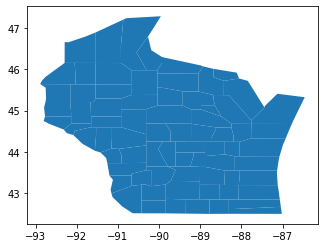

In [155]:
wisconsin_gdf.plot()

In [156]:
wisconsin_gdf[wisconsin_gdf.NAME=='Shawano']

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
1915,55,115,01581117,55115,Shawano,Shawano County,06,H1,G4020,267,43020,None,A,2313441748,41883060,+44.7896407,-088.7558134,"POLYGON ((-89.22401 44.85627, -89.22381 45.029..."


In [157]:
wisconsin_gdf[wisconsin_gdf.NAME=='Menominee']

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
3133,55,078,01581099,55078,Menominee,Menominee County,06,H1,G4020,267,43020,None,A,926217566,19022479,+44.9913041,-088.6692512,"POLYGON ((-88.98246 45.11800, -88.64116 45.117..."


In [158]:
combined = wisconsin_gdf[wisconsin_gdf.COUNTYFP.isin(['115', '078'])].dissolve(by='STATEFP')

<AxesSubplot:>

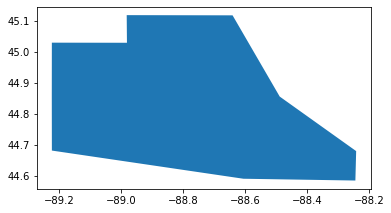

In [159]:
combined.plot()

In [160]:
combined.head()

,geometry,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
STATEFP,,,,,,,,,,,,,,,,,
55,"POLYGON ((-89.22401 44.85627, -89.22381 45.029...",115,01581117,55115,Shawano,Shawano County,06,H1,G4020,267,43020,None,A,2313441748,41883060,+44.7896407,-088.7558134


In [161]:
combined['NAME'] = "Shawano+Menominee"
combined['NAMELSAD'] = "Shawano+Menominee Counties"

In [162]:
combined.head()

,geometry,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
STATEFP,,,,,,,,,,,,,,,,,
55,"POLYGON ((-89.22401 44.85627, -89.22381 45.029...",115,01581117,55115,Shawano+Menominee,Shawano+Menominee Counties,06,H1,G4020,267,43020,None,A,2313441748,41883060,+44.7896407,-088.7558134


In [163]:
combined['GEOID'] = '55901'

In [164]:
combined.head()

,geometry,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
STATEFP,,,,,,,,,,,,,,,,,
55,"POLYGON ((-89.22401 44.85627, -89.22381 45.029...",115,01581117,55901,Shawano+Menominee,Shawano+Menominee Counties,06,H1,G4020,267,43020,None,A,2313441748,41883060,+44.7896407,-088.7558134


In [165]:
wisc0 = wisconsin_gdf[~wisconsin_gdf.COUNTYFP.isin(['115', '078'])]

<AxesSubplot:>

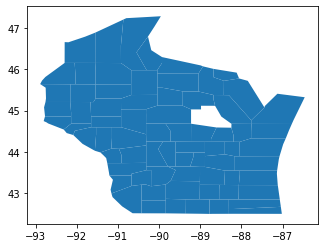

In [166]:
wisc0.plot()

In [167]:
wisc1 = pandas.concat([wisc0, combined])

<AxesSubplot:>

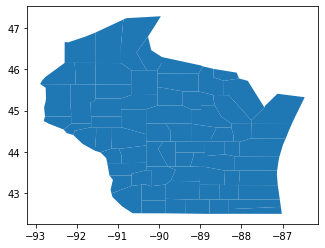

In [168]:
wisc1.plot()

In [169]:
wisc1.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
16,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,12660,None,A,2153685971,45692999,+43.4280010,-089.9433184,"POLYGON ((-90.19196 43.55500, -90.31107 43.553..."
145,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,33460,None,A,1486700515,48452318,+44.7253365,-092.4262793,"POLYGON ((-92.69454 44.68874, -92.73204 44.714..."
155,55,063,01581091,55063,La Crosse,La Crosse County,06,H1,G4020,None,29100,None,A,1170076618,73110198,+43.9082222,-091.1117584,"POLYGON ((-91.34774 43.91196, -91.42519 43.984..."
161,55,033,01581076,55033,Dunn,Dunn County,06,H1,G4020,232,32860,None,A,2201905281,35570217,+44.9477513,-091.8976451,"POLYGON ((-92.13538 44.94481, -92.15646 45.209..."
171,55,053,01581086,55053,Jackson,Jackson County,06,H1,G4020,None,None,None,A,2558687761,32538303,+44.3245897,-090.7995104,"POLYGON ((-91.16601 44.33510, -91.16562 44.596..."


In [170]:
wisc1.shape

(71, 18)

In [171]:
wisconsin_gdf.shape

(72, 18)

## Merge gdf and csv

In [172]:
csv['GeoFIPS'] = [fip.strip().replace("\"", "") for fip in csv.GeoFIPS]


In [173]:
wisc1.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
16,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,12660,None,A,2153685971,45692999,+43.4280010,-089.9433184,"POLYGON ((-90.19196 43.55500, -90.31107 43.553..."
145,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,33460,None,A,1486700515,48452318,+44.7253365,-092.4262793,"POLYGON ((-92.69454 44.68874, -92.73204 44.714..."
155,55,063,01581091,55063,La Crosse,La Crosse County,06,H1,G4020,None,29100,None,A,1170076618,73110198,+43.9082222,-091.1117584,"POLYGON ((-91.34774 43.91196, -91.42519 43.984..."
161,55,033,01581076,55033,Dunn,Dunn County,06,H1,G4020,232,32860,None,A,2201905281,35570217,+44.9477513,-091.8976451,"POLYGON ((-92.13538 44.94481, -92.15646 45.209..."
171,55,053,01581086,55053,Jackson,Jackson County,06,H1,G4020,None,None,None,A,2558687761,32538303,+44.3245897,-090.7995104,"POLYGON ((-91.16601 44.33510, -91.16562 44.596..."


In [174]:
wisc1.STATEFP='55'

In [175]:
data = csv

In [176]:
data.head()

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,9276,55000,Wisconsin,3,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,16424603,...,219514508,215913287,221895293,234574850,245700352,247127445,257572422,268237980,273787486,283635828
1,9277,55000,Wisconsin,3,CAINC1,2,...,Population (persons) 1/,Number of persons,4378000,...,5640996,5669264,5690403,5705812,5721075,5736673,5751272,5759744,5772917,5795483
2,9278,55000,Wisconsin,3,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3752,...,38914,38085,38995,41112,42947,43079,44785,46571,47426,48941
3,9279,55001,"Adams, WI",3,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,22995,...,584851,598851,610958,647126,672207,677315,690438,717115,723620,753940
4,9280,55001,"Adams, WI",3,CAINC1,2,...,Population (persons) 1/,Number of persons,8875,...,21101,20930,20886,20778,20426,20419,20135,20032,19997,19973


In [177]:
data['GEOID'] = data.GeoFIPS

In [178]:
data.GEOID

0      55000
1      55000
2      55000
3      55001
4      55001
       ...  
217    55141
218    55141
219    55901
220    55901
221    55901
Name: GEOID, Length: 216, dtype: object

## gdf records missing income values

In [179]:
#data = data[data.LineCode==3]
merged_gdf = wisc1.merge(data, on='GEOID')

In [180]:
set(wisc1.GEOID)

{'55001',
 '55003',
 '55005',
 '55007',
 '55009',
 '55011',
 '55013',
 '55015',
 '55017',
 '55019',
 '55021',
 '55023',
 '55025',
 '55027',
 '55029',
 '55031',
 '55033',
 '55035',
 '55037',
 '55039',
 '55041',
 '55043',
 '55045',
 '55047',
 '55049',
 '55051',
 '55053',
 '55055',
 '55057',
 '55059',
 '55061',
 '55063',
 '55065',
 '55067',
 '55069',
 '55071',
 '55073',
 '55075',
 '55077',
 '55079',
 '55081',
 '55083',
 '55085',
 '55087',
 '55089',
 '55091',
 '55093',
 '55095',
 '55097',
 '55099',
 '55101',
 '55103',
 '55105',
 '55107',
 '55109',
 '55111',
 '55113',
 '55117',
 '55119',
 '55121',
 '55123',
 '55125',
 '55127',
 '55129',
 '55131',
 '55133',
 '55135',
 '55137',
 '55139',
 '55141',
 '55901'}

<AxesSubplot:>

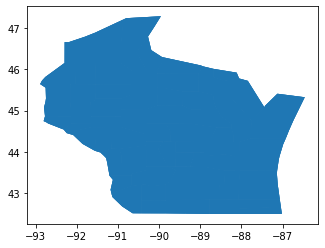

In [181]:
merged_gdf.plot()

In [182]:
merged_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,2162156,2130031,2247789,2365214,2495867,2553889,2688269,2800980,2832908,2933322
1,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,61231,61562,62072,62272,62415,62818,63005,63292,63604,63981
2,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,35311,34600,36213,37982,39988,40655,42668,44255,44540,45847
3,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,...,1428373,1372977,1429277,1529395,1592435,1605327,1706776,1785974,1801618,1870308
4,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,...,40758,40613,41065,40873,40705,40778,41003,41020,41428,41901


In [183]:
merged_gdf.shape[0]/3

71.0

In [184]:
matched_names = set(merged_gdf.NAMELSAD)

In [185]:
matched_names

{'Adams County',
 'Ashland County',
 'Barron County',
 'Bayfield County',
 'Brown County',
 'Buffalo County',
 'Burnett County',
 'Calumet County',
 'Chippewa County',
 'Clark County',
 'Columbia County',
 'Crawford County',
 'Dane County',
 'Dodge County',
 'Door County',
 'Douglas County',
 'Dunn County',
 'Eau Claire County',
 'Florence County',
 'Fond du Lac County',
 'Forest County',
 'Grant County',
 'Green County',
 'Green Lake County',
 'Iowa County',
 'Iron County',
 'Jackson County',
 'Jefferson County',
 'Juneau County',
 'Kenosha County',
 'Kewaunee County',
 'La Crosse County',
 'Lafayette County',
 'Langlade County',
 'Lincoln County',
 'Manitowoc County',
 'Marathon County',
 'Marinette County',
 'Marquette County',
 'Milwaukee County',
 'Monroe County',
 'Oconto County',
 'Oneida County',
 'Outagamie County',
 'Ozaukee County',
 'Pepin County',
 'Pierce County',
 'Polk County',
 'Portage County',
 'Price County',
 'Racine County',
 'Richland County',
 'Rock County',
 'R

In [186]:
missing_gdf = wisc1[~wisc1.GEOID.isin(merged_gdf.GEOID)]

In [187]:
missing_names = set(missing_gdf.NAMELSAD)

In [188]:
missing_names

set()

In [189]:
missing_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry


In [190]:
usva = geopandas.read_file('usva.shp')

In [191]:
us_no_wisc = usva[usva.STATEFP!='55']

In [192]:
us = pandas.concat([merged_gdf, us_no_wisc])

In [193]:
us.shape

(9237, 77)

In [194]:
9098/3

3032.6666666666665

<AxesSubplot:>

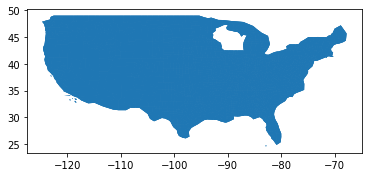

In [195]:
us_no_wisc.plot()

<AxesSubplot:>

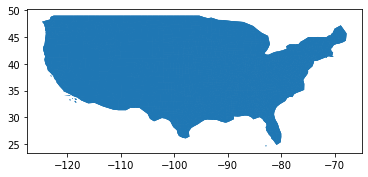

In [196]:
us.plot()

In [197]:
us.shape

(9237, 77)

In [198]:
9240/3

3080.0

In [199]:
us.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,index
0,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,2130031,2247789,2365214,2495867,2553889,2688269,2800980,2832908,2933322,NaN
1,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,61562,62072,62272,62415,62818,63005,63292,63604,63981,NaN
2,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,34600,36213,37982,39988,40655,42668,44255,44540,45847,NaN
3,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,...,1372977,1429277,1529395,1592435,1605327,1706776,1785974,1801618,1870308,NaN
4,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,...,40613,41065,40873,40705,40778,41003,41020,41428,41901,NaN


In [200]:
for y in range(1969, 2018):
    print(us[str(y)].dtype)

object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object


In [201]:
us.to_file('usincome.shp')

# Other

## Issue from BEA Income Data:
<LI>*&nbsp;Cibola, NM was separated from Valencia in June 1981, but in these estimates, Valencia includes Cibola through the end of 1981.</LI>
<LI>*&nbsp;La Paz County, AZ was separated from Yuma County on January 1, 1983. The Yuma, AZ MSA contains the area that became La Paz County, AZ through 1982 and excludes it beginning with 1983.</LI>

<LI>*&nbsp;Broomfield County, CO, was created from parts of Adams, Boulder, Jefferson, and Weld counties effective November 15, 2001. Estimates for Broomfield county begin with 2002.</LI>


### Approach

- combine Cibola NM with Valencia for 1981-2017
- combine La Paz County AZ with Yuma for 1983-2017
- combine Broomfield County with Boulder CO all years (<2002 Boulder, >2002 Boulder+Broomfield)



In [202]:
import pandas
import geopandas
%matplotlib inline

## NM

In [203]:
csv = pandas.read_csv('35.csv')

In [204]:
csv = csv.replace('(NA)', 0)

In [205]:
cibola = csv[csv.GeoName.str.startswith('Cibola')]
valencia = csv[csv.GeoName.str.startswith('Valencia')]

In [206]:
cibola

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
12,5562,"""35006""","Cibola, NM*",6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,0,...,612487,625209,641532,661228,669120,666997,703846,726953,733165,741683
13,5563,"""35006""","Cibola, NM*",6,CAINC1,2,...,Population (persons) 1/,Number of persons,0,...,27259,27097,27318,27470,27379,27341,27080,26976,26996,26853
14,5564,"""35006""","Cibola, NM*",6,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,0,...,22469,23073,23484,24071,24439,24395,25991,26948,27158,27620


In [207]:
valencia

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
99,5649,"""35061""","Valencia, NM*",6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,98031,...,2117211,2125302,2135646,2192910,2182250,2147723,2256080,2348505,2410723,2448624
100,5650,"""35061""","Valencia, NM*",6,CAINC1,2,...,Population (persons) 1/,Number of persons,40100,...,74879,75770,76789,76894,76693,76314,75750,75580,75639,75940
101,5651,"""35061""","Valencia, NM*",6,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,2445,...,28275,28049,27812,28519,28454,28143,29783,31073,31871,32244


In [208]:
years = [ str(y) for y in range(1969, 2018)]

In [209]:
combined = cibola.copy()
cibola[years] = cibola[years].astype(int)
valencia[years] = valencia[years].astype(int)
combined[years] = combined[years].astype(int)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3062: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [210]:
cindex = [ combined.columns.values.tolist().index(y) for y in years]

for c,y in zip(cindex,years):
    #print(menominee[y].dtype)
    #print(shawano[y].dtype)
    #print(combined[y].dtype)
    
    
    combined.iloc[0,c] = valencia.iloc[0,c] + cibola.iloc[0,c]
    combined.iloc[1,c] = valencia.iloc[1,c] + cibola.iloc[1,c]
    combined.iloc[2,c] = int(combined.iloc[0,c]*1000/ combined.iloc[1,c])
    #csv.iloc[219,c] = combined.iloc[0,c]
    #csv.iloc[220,c] = combined.iloc[1,c]
    #csv.iloc[221,c] = combined.iloc[2,c]


In [211]:
combined

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
12,5562,"""35006""","Cibola, NM*",6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,98031,...,2729698,2750511,2777178,2854138,2851370,2814720,2959926,3075458,3143888,3190307
13,5563,"""35006""","Cibola, NM*",6,CAINC1,2,...,Population (persons) 1/,Number of persons,40100,...,102138,102867,104107,104364,104072,103655,102830,102556,102635,102793
14,5564,"""35006""","Cibola, NM*",6,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,2444,...,26725,26738,26676,27347,27398,27154,28784,29988,30631,31036


## Drop Cibola and Valencia and Update Combined Fields

In [212]:
csv = csv.drop([12, 13, 14, 99, 100, 101])
combined['GeoName'] = 'Cibola+Valencia'
combined['GeoFIPS'] = '"35061"'

In [213]:
combined = combined[csv.columns]

csv = pandas.concat([csv, combined])

In [214]:
csv.head()

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,5550,"""35000""",New Mexico,6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,3143665,...,67065321,66678699,69261981,72820740,74583601,73406214,77747357,79953213,81184619,83127258
1,5551,"""35000""",New Mexico,6,CAINC1,2,...,Population (persons) 1/,Number of persons,1011000,...,2010662,2036802,2064607,2077744,2083590,2085161,2083207,2082264,2085432,2088070
2,5552,"""35000""",New Mexico,6,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3109,...,33355,32737,33547,35048,35796,35204,37321,38397,38929,39811
3,5553,"""35001""","Bernalillo, NM",6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,1101346,...,23279504,23208159,23599363,24626448,24931431,24552897,26109230,27106532,28090280,28550658
4,5554,"""35001""","Bernalillo, NM",6,CAINC1,2,...,Population (persons) 1/,Number of persons,314700,...,646879,655279,663999,669336,672335,673914,673902,674100,675588,676773


In [215]:
csv.tail()

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
97,5647,"""35059""","Union, NM",6,CAINC1,2,...,Population (persons) 1/,Number of persons,5000,...,4380,4523,4542,4407,4397,4341,4241,4157,4153,4187
98,5648,"""35059""","Union, NM",6,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3208,...,23414,24368,23421,31111,32129,28941,30788,33299,34916,34498
12,5562,"""35061""",Cibola+Valencia,6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,98031,...,2729698,2750511,2777178,2854138,2851370,2814720,2959926,3075458,3143888,3190307
13,5563,"""35061""",Cibola+Valencia,6,CAINC1,2,...,Population (persons) 1/,Number of persons,40100,...,102138,102867,104107,104364,104072,103655,102830,102556,102635,102793
14,5564,"""35061""",Cibola+Valencia,6,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,2444,...,26725,26738,26676,27347,27398,27154,28784,29988,30631,31036


In [216]:
gdf = geopandas.read_file("tl_2019_us_county.shp")

In [217]:
nm_gdf = gdf[gdf.STATEFP=="35"]

<AxesSubplot:>

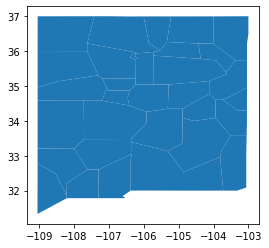

In [218]:
nm_gdf.plot()

In [219]:
nm_gdf[nm_gdf.NAME.isin(['Valencia', 'Cibola'])]

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
913,35,006,00933051,35006,Cibola,Cibola County,06,H1,G4020,None,24380,None,A,11758505180,5554603,+34.9282721,-107.9926805,"POLYGON ((-108.46969 35.13324, -107.30939 35.3..."
3146,35,061,00933052,35061,Valencia,Valencia County,06,H1,G4020,106,10740,None,A,2762854204,2760089,+34.7168404,-106.8065821,"POLYGON ((-107.02500 34.87102, -106.41178 34.8..."


In [220]:
combined = nm_gdf[nm_gdf.NAME.isin(['Valencia', 'Cibola'])].dissolve(by='STATEFP')

<AxesSubplot:>

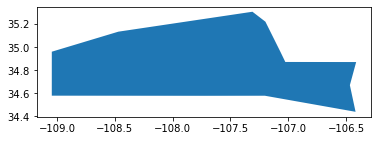

In [221]:
combined.plot()

In [222]:
combined['NAME'] = 'Cibola+Valencia'
combined['NAMELSAD'] = 'Cibola+Valencia Counties'
combined['STATEFP'] = 35

In [223]:
combined['GEOID'] =  '35061' # Valencia

In [224]:
nm0 = nm_gdf[~nm_gdf.COUNTYFP.isin(['006', '061'])]

<AxesSubplot:>

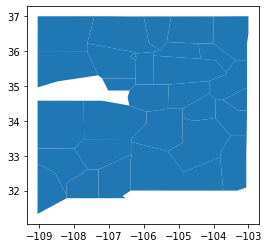

In [225]:
nm0.plot()

In [226]:
nm1 = pandas.concat([nm0, combined])

<AxesSubplot:>

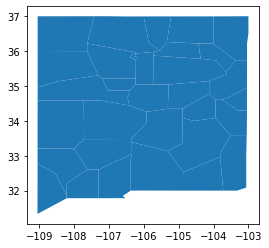

In [227]:
nm1.plot()

In [228]:
nm_gdf.shape

(33, 18)

In [229]:
nm1.shape

(32, 18)

In [230]:
csv['GeoFIPS'] = [fip.strip().replace("\"", "") for fip in csv.GeoFIPS]


In [231]:
data = csv
data['GEOID'] = data.GeoFIPS

In [232]:
merged_gdf = nm1.merge(data, on='GEOID')

In [233]:
merged_gdf.shape

(96, 76)

In [234]:
merged_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,...,60582,55832,65035,87470,82613,73262,78128,71494,74027,71733
1,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,...,2000,2002,2029,1996,1953,1921,1853,1868,1841,1829
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,...,30291,27888,32053,43823,42301,38137,42163,38273,40210,39220
3,35,035,00929104,35035,Otero,Otero County,06,H1,G4020,None,...,1731367,1825824,2005780,2086903,2084418,2032633,2083959,2117304,2174837,2224112
4,35,035,00929104,35035,Otero,Otero County,06,H1,G4020,None,...,62498,62462,64386,65432,65943,65677,64792,64178,65184,65817


In [235]:
us = geopandas.read_file('usincome.shp')

In [236]:
us1 = pandas.concat([us[us.STATEFP!='35'], merged_gdf])

In [237]:
us1.shape

(9234, 80)

In [238]:
us1.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2013,2014,2015,2016,2017,index,geometry,Unnamed: 0,IndustryClassification,Description
0,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,2553889,2688269,2800980,2832908,2933322,NaN,"POLYGON ((-90.19196 43.55500, -90.31107 43.553...",NaN,NaN,NaN
1,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,62818,63005,63292,63604,63981,NaN,"POLYGON ((-90.19196 43.55500, -90.31107 43.553...",NaN,NaN,NaN
2,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,40655,42668,44255,44540,45847,NaN,"POLYGON ((-90.19196 43.55500, -90.31107 43.553...",NaN,NaN,NaN
3,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,...,1605327,1706776,1785974,1801618,1870308,NaN,"POLYGON ((-92.69454 44.68874, -92.73204 44.714...",NaN,NaN,NaN
4,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,...,40778,41003,41020,41428,41901,NaN,"POLYGON ((-92.69454 44.68874, -92.73204 44.714...",NaN,NaN,NaN


In [239]:
us1.tail()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2013,2014,2015,2016,2017,index,geometry,Unnamed: 0,IndustryClassification,Description
91,35,051,01702370,35051,Sierra,Sierra County,06,H1,G4020,None,...,11524,11265,11233,11134,11116,NaN,"POLYGON ((-107.24564 33.47797, -107.22048 33.4...",5635.0,...,Population (persons) 1/
92,35,051,01702370,35051,Sierra,Sierra County,06,H1,G4020,None,...,31006,34516,36039,37248,38137,NaN,"POLYGON ((-107.24564 33.47797, -107.22048 33.4...",5636.0,...,Per capita personal income (dollars) 2/
93,35,006,00933051,35061,Cibola+Valencia,Cibola+Valencia Counties,06,H1,G4020,None,...,2814720,2959926,3075458,3143888,3190307,NaN,"POLYGON ((-107.02500 34.87102, -106.41178 34.8...",5562.0,...,Personal income (thousands of dollars)
94,35,006,00933051,35061,Cibola+Valencia,Cibola+Valencia Counties,06,H1,G4020,None,...,103655,102830,102556,102635,102793,NaN,"POLYGON ((-107.02500 34.87102, -106.41178 34.8...",5563.0,...,Population (persons) 1/
95,35,006,00933051,35061,Cibola+Valencia,Cibola+Valencia Counties,06,H1,G4020,None,...,27154,28784,29988,30631,31036,NaN,"POLYGON ((-107.02500 34.87102, -106.41178 34.8...",5564.0,...,Per capita personal income (dollars) 2/


In [240]:
9237/3

3079.0

In [241]:
merged_gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,...,60582,55832,65035,87470,82613,73262,78128,71494,74027,71733
1,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,...,2000,2002,2029,1996,1953,1921,1853,1868,1841,1829
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,...,30291,27888,32053,43823,42301,38137,42163,38273,40210,39220
3,35,035,00929104,35035,Otero,Otero County,06,H1,G4020,None,...,1731367,1825824,2005780,2086903,2084418,2032633,2083959,2117304,2174837,2224112
4,35,035,00929104,35035,Otero,Otero County,06,H1,G4020,None,...,62498,62462,64386,65432,65943,65677,64792,64178,65184,65817


In [242]:
us1[us1.NAME.str.startswith('Cibo')]

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2013,2014,2015,2016,2017,index,geometry,Unnamed: 0,IndustryClassification,Description
93,35,006,00933051,35061,Cibola+Valencia,Cibola+Valencia Counties,06,H1,G4020,None,...,2814720,2959926,3075458,3143888,3190307,NaN,"POLYGON ((-107.02500 34.87102, -106.41178 34.8...",5562.0,...,Personal income (thousands of dollars)
94,35,006,00933051,35061,Cibola+Valencia,Cibola+Valencia Counties,06,H1,G4020,None,...,103655,102830,102556,102635,102793,NaN,"POLYGON ((-107.02500 34.87102, -106.41178 34.8...",5563.0,...,Population (persons) 1/
95,35,006,00933051,35061,Cibola+Valencia,Cibola+Valencia Counties,06,H1,G4020,None,...,27154,28784,29988,30631,31036,NaN,"POLYGON ((-107.02500 34.87102, -106.41178 34.8...",5564.0,...,Per capita personal income (dollars) 2/


##  Arizona

- combine La Paz County AZ with Yuma for 1983-2017


In [243]:
csv = pandas.read_csv('04.csv')


In [244]:
csv.head()

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,369,"""04000""",Arizona,6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,6327071,...,223221865,211397715,215012419,225853155,236455566,242571877,257066980,270806695,280988093,296648898
1,370,"""04000""",Arizona,6,CAINC1,2,...,Population (persons) 1/,Number of persons,1737000,...,6280362,6343154,6407002,6465488,6544211,6616124,6706435,6802262,6908642,7016270
2,371,"""04000""",Arizona,6,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3643,...,35543,33327,33559,34932,36132,36664,38331,39811,40672,42280
3,372,"""04001""","Apache, AZ",6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,80748,...,1729352,1871824,1939280,1985382,1984948,2020967,2113963,2183667,2240006,2351874
4,373,"""04001""","Apache, AZ",6,CAINC1,2,...,Population (persons) 1/,Number of persons,34200,...,69883,71008,71838,72179,72215,72292,71762,70979,71373,71606


In [245]:
csv = csv.replace('(NA)', 0)

In [246]:
csv[csv.GeoName.str.startswith('La Paz')]

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
21,390,"""04012""","La Paz, AZ*",6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,0,...,529004,513123,516805,569046,552023,554562,558722,571915,608391,645531
22,391,"""04012""","La Paz, AZ*",6,CAINC1,2,...,Population (persons) 1/,Number of persons,0,...,20555,20514,20492,20582,20492,20479,20442,20342,20523,20601
23,392,"""04012""","La Paz, AZ*",6,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,0,...,25736,25013,25220,27648,26938,27080,27332,28115,29644,31335


In [247]:
csv[csv.GeoName.str.startswith('Yuma')]

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
45,414,"""04027""","Yuma, AZ*",6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,209506,...,5041311,5105829,5361748,5665534,5606527,5929784,5942092,6482641,6833428,7212166
46,415,"""04027""","Yuma, AZ*",6,CAINC1,2,...,Population (persons) 1/,Number of persons,59800,...,191202,193714,197124,202581,202105,201810,203039,203558,205463,207534
47,416,"""04027""","Yuma, AZ*",6,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3503,...,26366,26358,27200,27967,27741,29383,29266,31847,33259,34752


In [248]:
la_paz = csv.iloc[[21, 22, 23]]
yuma = csv.iloc[[45, 46, 47]]
combined = yuma.copy()
years = [str(y) for y in range(1969, 2018)]
la_paz[years] = la_paz[years].astype(int)
yuma[years] = yuma[years].astype(int)
combined[years] = combined[years].astype(int)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3062: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [249]:
cindex = [ combined.columns.values.tolist().index(y) for y in years]

for c,y in zip(cindex,years):
    #print(menominee[y].dtype)
    #print(shawano[y].dtype)
    #print(combined[y].dtype)
    combined.iloc[0,c] = la_paz.iloc[0,c] + yuma.iloc[0,c]
    combined.iloc[1,c] = la_paz.iloc[1,c] + yuma.iloc[1,c]
    combined.iloc[2,c] = int(combined.iloc[0,c]*1000/ combined.iloc[1,c])

In [250]:
combined

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
45,414,"""04027""","Yuma, AZ*",6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,209506,...,5570315,5618952,5878553,6234580,6158550,6484346,6500814,7054556,7441819,7857697
46,415,"""04027""","Yuma, AZ*",6,CAINC1,2,...,Population (persons) 1/,Number of persons,59800,...,211757,214228,217616,223163,222597,222289,223481,223900,225986,228135
47,416,"""04027""","Yuma, AZ*",6,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3503,...,26305,26228,27013,27937,27666,29170,29088,31507,32930,34443


In [251]:
csv = csv.drop([21, 22, 23, 45, 46, 47])
combined['GeoName'] = 'Yuma+La Paz'
combined['GeoFIPS'] = '"04027"'
combined['STATEFP'] = 4

In [252]:
combined = combined[csv.columns]

In [253]:
combined.head()

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
45,414,"""04027""",Yuma+La Paz,6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,209506,...,5570315,5618952,5878553,6234580,6158550,6484346,6500814,7054556,7441819,7857697
46,415,"""04027""",Yuma+La Paz,6,CAINC1,2,...,Population (persons) 1/,Number of persons,59800,...,211757,214228,217616,223163,222597,222289,223481,223900,225986,228135
47,416,"""04027""",Yuma+La Paz,6,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3503,...,26305,26228,27013,27937,27666,29170,29088,31507,32930,34443


In [254]:
csv = pandas.concat([csv, combined])

In [255]:
csv.shape

(45, 58)

In [256]:
csv.head()

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,369,"""04000""",Arizona,6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,6327071,...,223221865,211397715,215012419,225853155,236455566,242571877,257066980,270806695,280988093,296648898
1,370,"""04000""",Arizona,6,CAINC1,2,...,Population (persons) 1/,Number of persons,1737000,...,6280362,6343154,6407002,6465488,6544211,6616124,6706435,6802262,6908642,7016270
2,371,"""04000""",Arizona,6,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3643,...,35543,33327,33559,34932,36132,36664,38331,39811,40672,42280
3,372,"""04001""","Apache, AZ",6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,80748,...,1729352,1871824,1939280,1985382,1984948,2020967,2113963,2183667,2240006,2351874
4,373,"""04001""","Apache, AZ",6,CAINC1,2,...,Population (persons) 1/,Number of persons,34200,...,69883,71008,71838,72179,72215,72292,71762,70979,71373,71606


<AxesSubplot:>

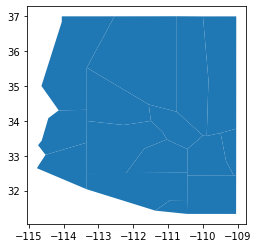

In [257]:
gdf = geopandas.read_file("tl_2019_us_county.shp")
az_gdf = gdf[gdf.STATEFP=='04']

az_gdf.plot()

In [258]:
az_gdf[az_gdf.NAME=='La Paz']

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
2389,04,012,00043540,04012,La Paz,La Paz County,06,H1,G4020,None,None,None,A,11645512187,36551630,+33.7276104,-114.0388060,"POLYGON ((-114.73122 33.30404, -114.62713 33.4..."


In [259]:
az_gdf[az_gdf.NAME=='Yuma']

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
398,04,027,00023901,04027,Yuma,Yuma County,06,H1,G4020,None,49740,None,A,14280777606,13248642,+32.7739424,-113.9109050,"POLYGON ((-114.76378 32.64340, -114.71950 32.7..."


In [260]:
combined = az_gdf[az_gdf.COUNTYFP.isin(['027', '012'])].dissolve(by='STATEFP')

<AxesSubplot:>

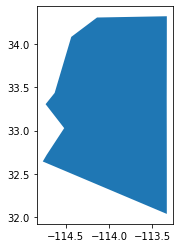

In [261]:
combined.plot()

In [262]:
combined['NAME']= "Yuma+La Paz"
combined['NAMELSAD'] = "Yuma+La Paz Counties"


In [263]:
combined.head()

,geometry,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
STATEFP,,,,,,,,,,,,,,,,,
04,"POLYGON ((-114.76378 32.64340, -114.71950 32.7...",027,00023901,04027,Yuma+La Paz,Yuma+La Paz Counties,06,H1,G4020,None,49740,None,A,14280777606,13248642,+32.7739424,-113.9109050


<AxesSubplot:>

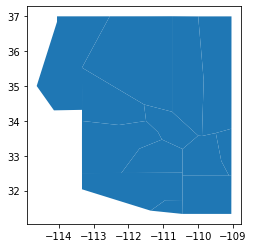

In [264]:
az0 = az_gdf[~az_gdf.COUNTYFP.isin(['027', '012'])]
az0.plot()

In [265]:
az1 = pandas.concat([az0, combined])

<AxesSubplot:>

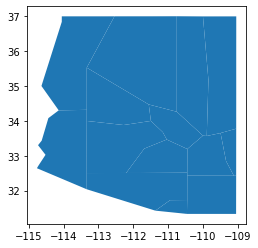

In [266]:
az1.plot()

## Merge gdf and csv

In [267]:
csv['GeoFIPS'] = [fip.strip().replace("\"", "") for fip in csv.GeoFIPS]


In [268]:
data = csv
data.head()

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,369,04000,Arizona,6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,6327071,...,223221865,211397715,215012419,225853155,236455566,242571877,257066980,270806695,280988093,296648898
1,370,04000,Arizona,6,CAINC1,2,...,Population (persons) 1/,Number of persons,1737000,...,6280362,6343154,6407002,6465488,6544211,6616124,6706435,6802262,6908642,7016270
2,371,04000,Arizona,6,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3643,...,35543,33327,33559,34932,36132,36664,38331,39811,40672,42280
3,372,04001,"Apache, AZ",6,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,80748,...,1729352,1871824,1939280,1985382,1984948,2020967,2113963,2183667,2240006,2351874
4,373,04001,"Apache, AZ",6,CAINC1,2,...,Population (persons) 1/,Number of persons,34200,...,69883,71008,71838,72179,72215,72292,71762,70979,71373,71606


In [269]:
data['GEOID'] = data.GeoFIPS

In [270]:
merged_gdf = az1.merge(data, on='GEOID')
merged_gdf['STATEFP'] = '04'

<AxesSubplot:>

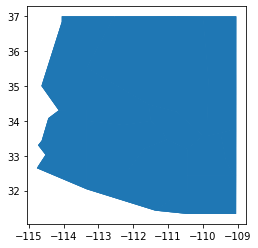

In [271]:
merged_gdf.plot()

In [272]:
us2 = pandas.concat([us1[us1.STATEFP!='04'], merged_gdf])

In [273]:
us2[us2.STATEFP=='04'].shape

(42, 80)

In [274]:
us2.shape[0]/3

3077.0

## Colorado

- combine Broomfield County with Boulder CO all years (<2002 Boulder, >2002 Boulder+Broomfield)


In [275]:
csv = pandas.read_csv('08.csv')

In [276]:
csv.head()

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,822,"""08000""",Colorado,7,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,8438834,...,207772729,198147196,204691900,222571956,236687388,248958974,271101038,284142915,289620855,306411131
1,823,"""08000""",Colorado,7,CAINC1,2,...,Population (persons) 1/,Number of persons,2166000,...,4889730,4972195,5048029,5116411,5186330,5262556,5342311,5440445,5530105,5607154
2,824,"""08000""",Colorado,7,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3896,...,42492,39851,40549,43502,45637,47308,50746,52228,52372,54646
3,825,"""08001""","Adams, CO*",7,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,648153,...,13471588,13410531,13630218,14634652,15609561,16355498,17657959,18834014,19705966,20738261
4,826,"""08001""","Adams, CO*",7,CAINC1,2,...,Population (persons) 1/,Number of persons,182656,...,424913,435700,443672,451443,459861,469377,479488,489822,497395,503167


In [277]:
csv[csv.GeoName.str.startswith('Boulder')]

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
21,843,"""08013""","Boulder, CO*",7,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,538596,...,15060376,13696406,14815455,15632452,16700010,17505391,18896217,20412704,20924309,21939604
22,844,"""08013""","Boulder, CO*",7,CAINC1,2,...,Population (persons) 1/,Number of persons,129577,...,290859,293190,295930,300518,305028,309749,312505,317968,321173,322514
23,845,"""08013""","Boulder, CO*",7,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,4157,...,51779,46715,50064,52018,54749,56515,60467,64197,65150,68027


In [278]:
csv[csv.GeoName.str.startswith('Broom')]

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
24,846,"""08014""","Broomfield, CO*",7,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,(NA),...,3333874,3130831,3035162,3230126,3441624,3306656,3557938,3804195,4011545,4346242
25,847,"""08014""","Broomfield, CO*",7,CAINC1,2,...,Population (persons) 1/,Number of persons,(NA),...,53181,54789,56214,57445,58899,60065,61706,64796,66509,68341
26,848,"""08014""","Broomfield, CO*",7,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,(NA),...,62689,57143,53993,56230,58433,55051,57660,58710,60316,63596


In [279]:
csv = csv.replace('(NA)', 0)
boulder = csv.iloc[[21, 22, 23]]
broomfield = csv.iloc[[24, 25, 26]]
combined = boulder.copy()
years = [str(y) for y in range(1989, 2018)]
boulder[years] = boulder[years].astype(int)
broomfield[years] = broomfield[years].astype(int)
combined[years] = combined[years].astype(int)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3062: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [280]:
cindex = [ combined.columns.values.tolist().index(y) for y in years]

for c,y in zip(cindex,years):
    #print(menominee[y].dtype)
    #print(shawano[y].dtype)
    #print(combined[y].dtype)
    combined.iloc[0,c] = boulder.iloc[0,c] + broomfield.iloc[0,c]
    combined.iloc[1,c] = boulder.iloc[1,c] + broomfield.iloc[1,c]
    combined.iloc[2,c] = int(combined.iloc[0,c]*1000/ combined.iloc[1,c])
    

In [281]:
csv = csv.drop([21, 22, 23, 24, 25, 26])
years = [str(y) for y in range(1969, 2018)]
csv[years] = csv[years].astype(int)

In [282]:
combined['GeoName'] = 'Boulder+Broomfield'
combined['GeoFIPS'] = '"08013"'

In [283]:
combined = combined[csv.columns]

csv = pandas.concat([csv, combined])

In [284]:
csv.head()

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,822,"""08000""",Colorado,7,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,8438834,...,207772729,198147196,204691900,222571956,236687388,248958974,271101038,284142915,289620855,306411131
1,823,"""08000""",Colorado,7,CAINC1,2,...,Population (persons) 1/,Number of persons,2166000,...,4889730,4972195,5048029,5116411,5186330,5262556,5342311,5440445,5530105,5607154
2,824,"""08000""",Colorado,7,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3896,...,42492,39851,40549,43502,45637,47308,50746,52228,52372,54646
3,825,"""08001""","Adams, CO*",7,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,648153,...,13471588,13410531,13630218,14634652,15609561,16355498,17657959,18834014,19705966,20738261
4,826,"""08001""","Adams, CO*",7,CAINC1,2,...,Population (persons) 1/,Number of persons,182656,...,424913,435700,443672,451443,459861,469377,479488,489822,497395,503167


In [285]:
csv.tail()

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
193,1015,"""08125""","Yuma, CO",7,CAINC1,2,...,Population (persons) 1/,Number of persons,8619,...,9843,10022,10052,10098,10076,10112,10175,10064,10118,10075
194,1016,"""08125""","Yuma, CO",7,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,3691,...,40339,33800,39139,44955,50129,50286,52608,54543,52271,55197
21,843,"""08013""",Boulder+Broomfield,7,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,538596,...,18394250,16827237,17850617,18862578,20141634,20812047,22454155,24216899,24935854,26285846
22,844,"""08013""",Boulder+Broomfield,7,CAINC1,2,...,Population (persons) 1/,Number of persons,129577,...,344040,347979,352144,357963,363927,369814,374211,382764,387682,390855
23,845,"""08013""",Boulder+Broomfield,7,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,4157,...,53465,48357,50691,52694,55345,56277,60003,63268,64320,67252


In [286]:
csv[csv.GeoName.str.startswith('Bould')]

,Unnamed: 0,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
21,843,"""08013""",Boulder+Broomfield,7,CAINC1,1,...,Personal income (thousands of dollars),Thousands of dollars,538596,...,18394250,16827237,17850617,18862578,20141634,20812047,22454155,24216899,24935854,26285846
22,844,"""08013""",Boulder+Broomfield,7,CAINC1,2,...,Population (persons) 1/,Number of persons,129577,...,344040,347979,352144,357963,363927,369814,374211,382764,387682,390855
23,845,"""08013""",Boulder+Broomfield,7,CAINC1,3,...,Per capita personal income (dollars) 2/,Dollars,4157,...,53465,48357,50691,52694,55345,56277,60003,63268,64320,67252


<AxesSubplot:>

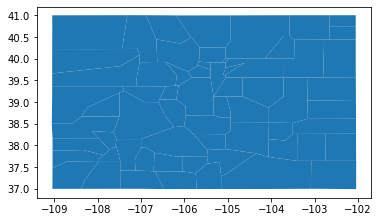

In [287]:
gdf = geopandas.read_file("tl_2019_us_county.shp")

co_gdf = gdf[gdf.STATEFP=='08']

co_gdf.plot()

In [288]:
co_gdf[co_gdf.NAME=='Boulder']

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
617,08,013,00198122,08013,Boulder,Boulder County,06,H1,G4020,216,14500,None,A,1881309466,36493405,+40.0949699,-105.3976911,"POLYGON ((-105.64858 40.06198, -105.65332 40.2..."


In [289]:
co_gdf[co_gdf.NAME=='Broomfield']

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
693,08,014,01945881,08014,Broomfield,Broomfield County,06,H6,G4020,216,19740,None,C,85478765,1411396,+39.9535933,-105.0507868,"POLYGON ((-105.16606 39.90177, -105.14714 39.9..."


In [290]:
combined = co_gdf[co_gdf.COUNTYFP.isin(['013', '014'])].dissolve(by='STATEFP')

<AxesSubplot:>

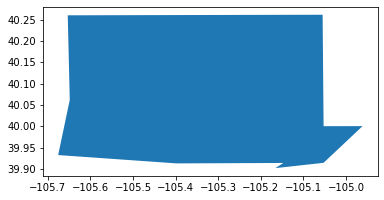

In [291]:
combined.plot()

In [292]:
combined.head()

,geometry,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
STATEFP,,,,,,,,,,,,,,,,,
08,"POLYGON ((-105.16606 39.90177, -105.14714 39.9...",013,00198122,08013,Boulder,Boulder County,06,H1,G4020,216,14500,None,A,1881309466,36493405,+40.0949699,-105.3976911


In [293]:
combined['NAME'] = "Boulder+Bloomfield"
combined['NAMELSAD'] = "Boulder+Bloomfield Counties"


In [294]:
combined['GEOID'] = '08013'

In [295]:
combined.columns

Index(['geometry', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON'],
      dtype='object')

<AxesSubplot:>

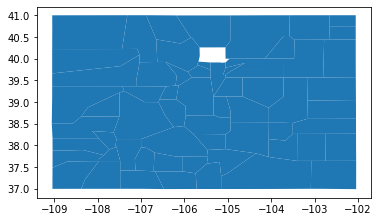

In [296]:
co0 = co_gdf[~co_gdf.COUNTYFP.isin(['013', '014'])]
co0.plot()

<AxesSubplot:>

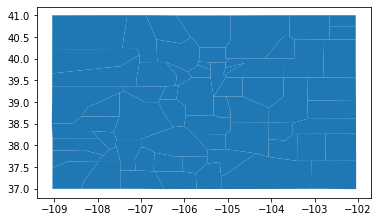

In [297]:
co1 = pandas.concat([co0, combined])
co1.plot()

<AxesSubplot:>

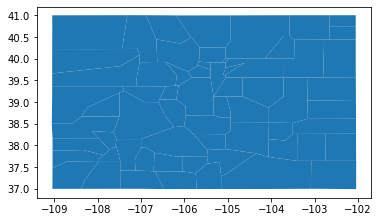

In [298]:
co_gdf.plot()

In [299]:
co1.shape

(63, 18)

In [300]:
co_gdf.shape

(64, 18)

In [301]:
csv['GeoFIPS'] = [fip.strip().replace("\"", "") for fip in csv.GeoFIPS]


In [302]:
data = csv
data['GEOID'] = data.GeoFIPS

In [303]:
merged = co1.merge(data, on='GEOID')
merged['STATEFP'] = '08'

In [304]:
merged[merged.NAME.str.startswith('Bould')]['STATEFP']

186    08
187    08
188    08
Name: STATEFP, dtype: object

In [305]:
co1.shape

(63, 18)

In [306]:
merged.shape

(189, 76)

In [307]:
data.shape

(192, 59)

<AxesSubplot:>

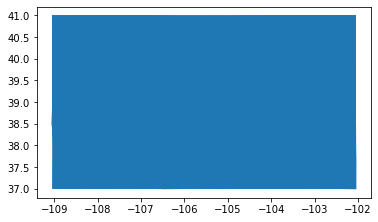

In [308]:
merged.plot()

In [309]:
merged.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,08,109,00198170,08109,Saguache,Saguache County,06,H1,G4020,None,...,156564,152865,155801,173600,165653,164698,173175,195695,194028,199669
1,08,109,00198170,08109,Saguache,Saguache County,06,H1,G4020,None,...,6179,6134,6136,6177,6320,6232,6186,6239,6407,6626
2,08,109,00198170,08109,Saguache,Saguache County,06,H1,G4020,None,...,25338,24921,25391,28104,26211,26428,27995,31366,30284,30134
3,08,115,00198173,08115,Sedgwick,Sedgwick County,06,H1,G4020,None,...,97147,88093,97610,111612,115857,120594,126242,122217,111805,122738
4,08,115,00198173,08115,Sedgwick,Sedgwick County,06,H1,G4020,None,...,2421,2392,2368,2366,2373,2335,2329,2370,2405,2344


In [310]:
us2.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2013,2014,2015,2016,2017,index,geometry,Unnamed: 0,IndustryClassification,Description
0,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,2553889,2688269,2800980,2832908,2933322,NaN,"POLYGON ((-90.19196 43.55500, -90.31107 43.553...",NaN,NaN,NaN
1,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,62818,63005,63292,63604,63981,NaN,"POLYGON ((-90.19196 43.55500, -90.31107 43.553...",NaN,NaN,NaN
2,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,40655,42668,44255,44540,45847,NaN,"POLYGON ((-90.19196 43.55500, -90.31107 43.553...",NaN,NaN,NaN
3,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,...,1605327,1706776,1785974,1801618,1870308,NaN,"POLYGON ((-92.69454 44.68874, -92.73204 44.714...",NaN,NaN,NaN
4,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,...,40778,41003,41020,41428,41901,NaN,"POLYGON ((-92.69454 44.68874, -92.73204 44.714...",NaN,NaN,NaN


In [311]:
us3 = pandas.concat([us2[us2.STATEFP!='08'], merged])

In [312]:
us3.shape[0]/3

3076.0

In [313]:
us2.shape[0]/3

3077.0

In [314]:
us3

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2013,2014,2015,2016,2017,index,geometry,Unnamed: 0,IndustryClassification,Description
0,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,2553889,2688269,2800980,2832908,2933322,NaN,"POLYGON ((-90.19196 43.55500, -90.31107 43.553...",NaN,NaN,NaN
1,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,62818,63005,63292,63604,63981,NaN,"POLYGON ((-90.19196 43.55500, -90.31107 43.553...",NaN,NaN,NaN
2,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,40655,42668,44255,44540,45847,NaN,"POLYGON ((-90.19196 43.55500, -90.31107 43.553...",NaN,NaN,NaN
3,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,...,1605327,1706776,1785974,1801618,1870308,NaN,"POLYGON ((-92.69454 44.68874, -92.73204 44.714...",NaN,NaN,NaN
4,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,...,40778,41003,41020,41428,41901,NaN,"POLYGON ((-92.69454 44.68874, -92.73204 44.714...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,08,049,00198140,08049,Grand,Grand County,06,H1,G4020,None,...,14296,14536,14685,15129,15321,NaN,"POLYGON ((-106.08984 40.35006, -105.85493 40.4...",901.0,...,Population (persons) 1/
185,08,049,00198140,08049,Grand,Grand County,06,H1,G4020,None,...,38618,41381,43964,44391,46013,NaN,"POLYGON ((-106.08984 40.35006, -105.85493 40.4...",902.0,...,Per capita personal income (dollars) 2/
186,08,013,00198122,08013,Boulder+Bloomfield,Boulder+Bloomfield Counties,06,H1,G4020,216,...,20812047,22454155,24216899,24935854,26285846,NaN,"POLYGON ((-105.16606 39.90177, -105.14714 39.9...",843.0,...,Personal income (thousands of dollars)
187,08,013,00198122,08013,Boulder+Bloomfield,Boulder+Bloomfield Counties,06,H1,G4020,216,...,369814,374211,382764,387682,390855,NaN,"POLYGON ((-105.16606 39.90177, -105.14714 39.9...",844.0,...,Population (persons) 1/


In [315]:
us3[us3.STATEFP=='08'].tail()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2013,2014,2015,2016,2017,index,geometry,Unnamed: 0,IndustryClassification,Description
184,08,049,00198140,08049,Grand,Grand County,06,H1,G4020,None,...,14296,14536,14685,15129,15321,NaN,"POLYGON ((-106.08984 40.35006, -105.85493 40.4...",901.0,...,Population (persons) 1/
185,08,049,00198140,08049,Grand,Grand County,06,H1,G4020,None,...,38618,41381,43964,44391,46013,NaN,"POLYGON ((-106.08984 40.35006, -105.85493 40.4...",902.0,...,Per capita personal income (dollars) 2/
186,08,013,00198122,08013,Boulder+Bloomfield,Boulder+Bloomfield Counties,06,H1,G4020,216,...,20812047,22454155,24216899,24935854,26285846,NaN,"POLYGON ((-105.16606 39.90177, -105.14714 39.9...",843.0,...,Personal income (thousands of dollars)
187,08,013,00198122,08013,Boulder+Bloomfield,Boulder+Bloomfield Counties,06,H1,G4020,216,...,369814,374211,382764,387682,390855,NaN,"POLYGON ((-105.16606 39.90177, -105.14714 39.9...",844.0,...,Population (persons) 1/
188,08,013,00198122,08013,Boulder+Bloomfield,Boulder+Bloomfield Counties,06,H1,G4020,216,...,56277,60003,63268,64320,67252,NaN,"POLYGON ((-105.16606 39.90177, -105.14714 39.9...",845.0,...,Per capita personal income (dollars) 2/


In [316]:
us3[us3.NAME.str.startswith('Boulder')]

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2013,2014,2015,2016,2017,index,geometry,Unnamed: 0,IndustryClassification,Description
186,08,013,00198122,08013,Boulder+Bloomfield,Boulder+Bloomfield Counties,06,H1,G4020,216,...,20812047,22454155,24216899,24935854,26285846,NaN,"POLYGON ((-105.16606 39.90177, -105.14714 39.9...",843.0,...,Personal income (thousands of dollars)
187,08,013,00198122,08013,Boulder+Bloomfield,Boulder+Bloomfield Counties,06,H1,G4020,216,...,369814,374211,382764,387682,390855,NaN,"POLYGON ((-105.16606 39.90177, -105.14714 39.9...",844.0,...,Population (persons) 1/
188,08,013,00198122,08013,Boulder+Bloomfield,Boulder+Bloomfield Counties,06,H1,G4020,216,...,56277,60003,63268,64320,67252,NaN,"POLYGON ((-105.16606 39.90177, -105.14714 39.9...",845.0,...,Per capita personal income (dollars) 2/


In [317]:
us3.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'Unnamed_ 0', 'GeoFIPS', 'GeoName',
       'Region', 'TableName', 'LineCode', 'IndustryCl', 'Descriptio', 'Unit',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', 'index', 'geometry', 'Unnamed: 0',
       'IndustryClassification', 'Description'],
      dtype='object')

In [318]:
columns = us3.columns
print(columns)


Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'Unnamed_ 0', 'GeoFIPS', 'GeoName',
       'Region', 'TableName', 'LineCode', 'IndustryCl', 'Descriptio', 'Unit',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', 'index', 'geometry', 'Unnamed: 0',
       'IndustryClassification', 'Description'],
      dtype='object')


In [319]:
us3.shape

(9228, 80)

In [320]:
columns = us3.columns.values.tolist()
columns

['STATEFP',
 'COUNTYFP',
 'COUNTYNS',
 'GEOID',
 'NAME',
 'NAMELSAD',
 'LSAD',
 'CLASSFP',
 'MTFCC',
 'CSAFP',
 'CBSAFP',
 'METDIVFP',
 'FUNCSTAT',
 'ALAND',
 'AWATER',
 'INTPTLAT',
 'INTPTLON',
 'Unnamed_ 0',
 'GeoFIPS',
 'GeoName',
 'Region',
 'TableName',
 'LineCode',
 'IndustryCl',
 'Descriptio',
 'Unit',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 'index',
 'geometry',
 'Unnamed: 0',
 'IndustryClassification',
 'Description']

In [321]:
us3.loc[:,'Unnamed: 0']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
       ...  
184    901.0
185    902.0
186    843.0
187    844.0
188    845.0
Name: Unnamed: 0, Length: 9228, dtype: float64

In [322]:
us3.shape

(9228, 80)

In [323]:
us4 = us3.drop(columns=['Unnamed: 0', 'Unnamed_ 0', 'IndustryCl'])

In [324]:
us4.shape

(9228, 77)

In [325]:
for year in range(1969, 2018):
    year = str(year)
    us4[year] = us4[year].astype('int')

In [326]:
us4.to_file('usincome_final.shp')

In [327]:
us4.shape

(9228, 77)

## Shrinking file size
We are duplicating the shapes three times (once for each attribute)

Split out the attributes from the geometries, two different dataframes

In [328]:
gdf = geopandas.read_file('usincome_final.shp')

In [329]:
uscountyincome = pandas.DataFrame(gdf.drop(columns='geometry'))

In [330]:
uscountyincome.to_csv('uscountyincome.csv')

In [331]:
gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2012,2013,2014,2015,2016,2017,index,IndustryCl,Descript_1,geometry
0,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,2495867,2553889,2688269,2800980,2832908,2933322,NaN,None,None,"POLYGON ((-90.19196 43.55500, -90.31107 43.553..."
1,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,62415,62818,63005,63292,63604,63981,NaN,None,None,"POLYGON ((-90.19196 43.55500, -90.31107 43.553..."
2,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,39988,40655,42668,44255,44540,45847,NaN,None,None,"POLYGON ((-90.19196 43.55500, -90.31107 43.553..."
3,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,...,1592435,1605327,1706776,1785974,1801618,1870308,NaN,None,None,"POLYGON ((-92.69454 44.68874, -92.73204 44.714..."
4,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,...,40705,40778,41003,41020,41428,41901,NaN,None,None,"POLYGON ((-92.69454 44.68874, -92.73204 44.714..."


In [332]:
gdf.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'GeoFIPS', 'GeoName', 'Region',
       'TableName', 'LineCode', 'Descriptio', 'Unit', '1969', '1970', '1971',
       '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', 'index', 'IndustryCl', 'Descript_1', 'geometry'],
      dtype='object')

In [333]:
gdf.LineCode

0       1
1       2
2       3
3       1
4       2
       ..
9223    2
9224    3
9225    1
9226    2
9227    3
Name: LineCode, Length: 9228, dtype: object

In [334]:
gdf = gdf[gdf.LineCode=="3"]

In [335]:
gdf.shape

(3076, 77)

In [336]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<AxesSubplot:>

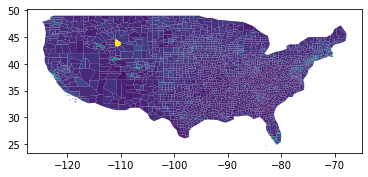

In [337]:
gdf.plot(column='2017')

In [338]:
gdf.to_file("uscountypcincome.gpkg", layer='pcincome', driver="GPKG")

In [339]:
gdf.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'GeoFIPS', 'GeoName', 'Region',
       'TableName', 'LineCode', 'Descriptio', 'Unit', '1969', '1970', '1971',
       '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', 'index', 'IndustryCl', 'Descript_1', 'geometry'],
      dtype='object')

In [340]:
gdf.shape

(3076, 77)